# Land Carbon Sink Analysis

Main notebook for the Land Carbon Sink Analysis project.

In [1]:
import os
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy.stats import skew
import seaborn
from pySankey.sankey import sankey
from pandas.api.types import CategoricalDtype
from IPython.display import display, Markdown

In [2]:
# directories
checkDir = "../data/check/"
rawDir = "../data/raw/"
interimDir = "../data/interim/"
processedDir = "../data/processed/"
imgDir = "../img/"

# create directories if they do not exist
directories = [checkDir, rawDir, interimDir, processedDir, imgDir]
for directory in directories:
    if not os.path.exists(directory):
        os.makedirs(directory)

# Data import

In [3]:
SLAND_country = xr.open_dataset(rawDir + "GCB2023_SLAND_country_mask.nc")

terrestrial_sink = pd.read_excel(rawDir + "Global_Carbon_Budget_2023v1.1.xlsx", sheet_name="Terrestrial Sink",
    header=27)  # Row 28 has column names

# Drop column 'C' since it is empty
terrestrial_sink = terrestrial_sink.drop(columns=["Unnamed: 2"])

# View the resulting DataFrame
print(terrestrial_sink.head())

# Filter the DataFrame for the years 2013 to 2022
filtered_terrestrial_sink = terrestrial_sink[
    (terrestrial_sink["Year"] >= 2013) & (terrestrial_sink["Year"] <= 2022)
]

# Calculate the mean of the 'GCB' column for the filtered years
mean_gcb = filtered_terrestrial_sink["GCB"].mean()

   Year       GCB  CABLE-POP  CLASSIC    CLM5.0      DLEM        ED       ELM  \
0  1959  0.430359  -0.297389   0.3162  0.276912  0.434518  0.711015  0.864334   
1  1960  1.252347   2.137762   1.1037  1.790785  1.671215  1.142080  1.738872   
2  1961  0.899620   1.676709   0.8056  0.885000  1.341876  2.086029  1.270117   
3  1962  1.293962   1.831520   1.0017  0.334234  1.855886  1.718834  1.641357   
4  1963  0.959732   1.392875   0.0056  1.719622  1.172225  1.306013  1.397455   

       IBIS      ISAM  ...     LPJml  LPX-Bern     OCNv2  ORCHIDEE-v3  \
0  0.568455  1.483840  ...  0.039440  0.328832  0.889957     0.549868   
1  1.084692  1.341953  ...  1.572189  0.689288  1.060378     1.176620   
2  0.559826  0.957341  ...  0.131270  0.437127  1.466082     0.856589   
3  0.961032  1.470531  ...  1.058574  0.165028  1.700229     1.542580   
4  0.323399  1.156859  ...  0.328858  0.215212  1.540279     0.770386   

      SDGVM  VISIT     YIBs  Unnamed: 23  Multi-model mean  Model Spread (

In [4]:
# Load the mapping from the Excel file
iso_df = pd.read_excel(rawDir + "iso_mapping.xlsx")
iso_mapping = dict(zip(iso_df['country'], iso_df['iso']))
country_mapping = dict(zip(iso_df['iso'], iso_df['country']))
print(list(country_mapping.keys())[:5])  # Show example keys
print(list(iso_mapping.values())[:5])  # Show example keys

# Other mappings
sovereign_iso = dict(zip(iso_df['country'], iso_df['sovereign']))
sovereign_country = dict(zip(iso_df['sovereign'], iso_df['sovereign_country']))
sovereign_iso_iso = dict(zip(iso_df['iso'], iso_df['sovereign']))

['ABW', 'AFG', 'AGO', 'AIA', 'ALA']
['ABW', 'AFG', 'AGO', 'AIA', 'ALA']


In [5]:
# Number of bootstrap iterations
n_draws = 100000

# SLAND

### Estimates

In [6]:
# Filter years
years_slice = slice(2013, 2022)
sland = SLAND_country["SLAND"].sel(year=years_slice)
sland_forest = SLAND_country["SLAND_total_forest"].sel(year=years_slice)
sland_managed = SLAND_country["SLAND_managed_forest"].sel(year=years_slice)

# Convert to DataFrames
df_sland = sland.to_dataframe().reset_index()
df_forest = sland_forest.to_dataframe().reset_index()
df_managed = sland_managed.to_dataframe().reset_index()

# Merge them on country, model, and year
df = df_sland.merge(df_forest, on=["country", "model", "year"], suffixes=('', '_total_forest'))
df = df.merge(df_managed, on=["country", "model", "year"])

# Remove Somaliland
country_ids = SLAND_country["country"].values
if "names" in SLAND_country["country"].attrs:
    country_names = SLAND_country["country"].attrs["names"].split(", ")
else:
    country_names = [str(c) for c in country_ids]

country_map = dict(zip(country_ids, country_names))
df["country_name"] = df["country"].map(country_map)
df = df[df["country_name"] != "Somaliland"]

# Add ISO codes
df["iso"] = df["country_name"].map(iso_mapping)

# Unit conversion
factor = 1e-12 * (60 * 60 * 24 * 365)  # PgC/yr to GtC/yr
df["SLAND"] *= factor * -1  # SLAND is negative
df["SLAND_total_forest"] *= factor * -1 
df["SLAND_managed_forest"] *= factor * -1

# Final column order
df_sland = df[["iso", "country_name", "year", "model", "SLAND", "SLAND_total_forest", "SLAND_managed_forest"]]
df_sland = df_sland.rename(columns={"country_name": "country"})

# Sort by country
df_sland = df_sland.sort_values(by=["country", "model"])



#### Statistics

In [7]:
# Group by country and iso to compute stats across all years/models
df_sland_stats = df_sland.groupby(["country", "iso"]).agg(
    Fa_mean=("SLAND", "mean"),
    Fa_std=("SLAND", "std"),
    Fa_skew=("SLAND", lambda x: skew(x, nan_policy="omit")),
    Fa_median=("SLAND", "median"),
    Fa_q17=("SLAND", lambda x: np.nanpercentile(x, 17)),
    Fa_q83=("SLAND", lambda x: np.nanpercentile(x, 83)),
    Fa_min=("SLAND", "min"),
    Fa_max=("SLAND", "max"),

    Fa_tf_mean=("SLAND_total_forest", "mean"),
    Fa_tf_std=("SLAND_total_forest", "std"),
    Fa_tf_skew=("SLAND_total_forest", lambda x: skew(x, nan_policy="omit")),
    Fa_tf_median=("SLAND_total_forest", "median"),
    Fa_tf_q17=("SLAND_total_forest", lambda x: np.nanpercentile(x, 17)),
    Fa_tf_q83=("SLAND_total_forest", lambda x: np.nanpercentile(x, 83)),
    Fa_tf_min=("SLAND_total_forest", "min"),
    Fa_tf_max=("SLAND_total_forest", "max"),

    Fa_mf_mean=("SLAND_managed_forest", "mean"),
    Fa_mf_std=("SLAND_managed_forest", "std"),
    Fa_mf_skew=("SLAND_managed_forest", lambda x: skew(x, nan_policy="omit")),
    Fa_mf_median=("SLAND_managed_forest", "median"),
    Fa_mf_q17=("SLAND_managed_forest", lambda x: np.nanpercentile(x, 17)),
    Fa_mf_q83=("SLAND_managed_forest", lambda x: np.nanpercentile(x, 83)),
    Fa_mf_min=("SLAND_managed_forest", "min"),
    Fa_mf_max=("SLAND_managed_forest", "max"),
).reset_index()

# Sort by ISO code
df_sland_stats = df_sland_stats.sort_values(by="iso").reset_index(drop=True)

In [8]:
print("Country Sum Land Sink (Gt per yr): ", df_sland_stats["Fa_mean"].sum())

print("Country Sum Land Sink with total forest (Gt per yr): ", df_sland_stats["Fa_tf_mean"].sum())
print("Country Sum Land Sink with managed forest (Gt per yr): ", df_sland_stats["Fa_mf_mean"].sum())

print("Country Sum Land Sink (Gt per yr) from GCB Excel: ", mean_gcb*-1)

Country Sum Land Sink (Gt per yr):  -3.3731966
Country Sum Land Sink with total forest (Gt per yr):  -2.2139275
Country Sum Land Sink with managed forest (Gt per yr):  -1.7126535
Country Sum Land Sink (Gt per yr) from GCB Excel:  -3.3490033956991168


## Sovereign

In [9]:
# Make a copy so the original df_sland is unchanged
df_sland_tmp = df_sland.copy()

# Replace iso codes with sovereign iso codes
df_sland_tmp["sovereign_iso"] = df_sland_tmp["iso"].map(sovereign_iso_iso)

# Add the sovereign country name
df_sland_tmp["sovereign_country"] = df_sland_tmp["sovereign_iso"].map(sovereign_country)

# Group by sovereign_iso, model, year — sum SLAND values
df_sland_sovereign = (
    df_sland_tmp
    .groupby(["sovereign_iso", "sovereign_country", "model", "year"], as_index=False)
    [["SLAND", "SLAND_total_forest", "SLAND_managed_forest"]]
    .sum()
)

# Rename for consistency
df_sland_sovereign = df_sland_sovereign.rename(columns={
    "sovereign_iso": "iso",
    "sovereign_country": "country"
})

In [10]:
# Identify mappings where original ISO was replaced with a sovereign ISO
aggregated_isos = {
    orig_iso: sovereign_iso_iso[orig_iso]
    for orig_iso in df_sland["iso"].unique()
    if orig_iso in sovereign_iso_iso and sovereign_iso_iso[orig_iso] != orig_iso
}

# Print the mappings
if aggregated_isos:
    print("Aggregated ISO columns:")
    for orig_iso, sovereign_iso in sorted(aggregated_isos.items()):
        orig_country = country_mapping.get(orig_iso, "Unknown")
        new_country = sovereign_country.get(sovereign_iso, country_mapping.get(sovereign_iso, "Unknown"))
        print(f"{orig_iso} ({orig_country}) ➝ {sovereign_iso} ({new_country})")
else:
    print("No ISO columns aggregated into sovereigns.")

Aggregated ISO columns:
ALA (Aland) ➝ FIN (Finland)
ATF (French Southern and Antarctic Lands) ➝ FRA (France)
BAY (Baykonur Cosmodrome) ➝ KAZ (Kazakhstan)
CYM (Cayman Islands) ➝ GBR (United Kingdom)
CYN (Northern Cyprus) ➝ CYP (Cyprus)
FLK (Falkland Islands) ➝ GBR (United Kingdom)
FRO (Faroe Islands) ➝ DNK (Denmark)
GRL (Greenland) ➝ DNK (Denmark)
HKG (Hong Kong S.A.R.) ➝ CHN (China)
NCL (New Caledonia) ➝ FRA (France)
PRI (Puerto Rico) ➝ USA (United States of America)
PYF (French Polynesia) ➝ FRA (France)
SGR (Siachen Glacier) ➝ IND (India)
SGS (South Georgia and the Islands) ➝ GBR (United Kingdom)
VIR (United States Virgin Islands) ➝ USA (United States of America)


### Statistics

In [11]:
# Group by country and iso to compute stats across all years/models
df_sland_sovereign_stats = df_sland_sovereign.groupby(["country", "iso"]).agg(
    Fa_mean=("SLAND", "mean"),
    Fa_std=("SLAND", "std"),
    Fa_skew=("SLAND", lambda x: skew(x, nan_policy="omit")),
    Fa_median=("SLAND", "median"),
    Fa_q17=("SLAND", lambda x: np.nanpercentile(x, 17)),
    Fa_q83=("SLAND", lambda x: np.nanpercentile(x, 83)),
    Fa_min=("SLAND", "min"),
    Fa_max=("SLAND", "max"),

    Fa_tf_mean=("SLAND_total_forest", "mean"),
    Fa_tf_std=("SLAND_total_forest", "std"),
    Fa_tf_skew=("SLAND_total_forest", lambda x: skew(x, nan_policy="omit")),
    Fa_tf_median=("SLAND_total_forest", "median"),
    Fa_tf_q17=("SLAND_total_forest", lambda x: np.nanpercentile(x, 17)),
    Fa_tf_q83=("SLAND_total_forest", lambda x: np.nanpercentile(x, 83)),
    Fa_tf_min=("SLAND_total_forest", "min"),
    Fa_tf_max=("SLAND_total_forest", "max"),

    Fa_mf_mean=("SLAND_managed_forest", "mean"),
    Fa_mf_std=("SLAND_managed_forest", "std"),
    Fa_mf_skew=("SLAND_managed_forest", lambda x: skew(x, nan_policy="omit")),
    Fa_mf_median=("SLAND_managed_forest", "median"),
    Fa_mf_q17=("SLAND_managed_forest", lambda x: np.nanpercentile(x, 17)),
    Fa_mf_q83=("SLAND_managed_forest", lambda x: np.nanpercentile(x, 83)),
    Fa_mf_min=("SLAND_managed_forest", "min"),
    Fa_mf_max=("SLAND_managed_forest", "max"),
).reset_index()

# Sort by ISO code
df_sland_sovereign_stats = df_sland_sovereign_stats.sort_values(by="iso").reset_index(drop=True)

## Bootstrapping

1. Prepare and save dataframe: naming convention "{output_name}_boot.csv"
2. calculate statistics, assign country name and sort
3. Print the sum of all country mean and median
4. prepare residual dataset for wealth calculations

In [12]:
def process_bootstrapping(df, variable_name, stat_prefix, output_name, country_map):
    # Filter only the necessary columns
    df_subset = df[["iso", variable_name]]

    # Group by iso and collect values as lists
    grouped = df_subset.groupby("iso")[variable_name].apply(list)
    df_transformed = pd.DataFrame(dict(grouped))

    # Drop "Total" column and perform bootstrapping
    df_boot = df_transformed.drop(columns="Total", errors="ignore").copy()
    df_boot = df_boot.sample(n=n_draws, replace=True, random_state=11) # SLAND 11!!!
    df_boot.reset_index(drop=True, inplace=True)

    # Add the "Total" column
    df_boot["Total"] = df_boot.sum(axis=1)


    # Statistics
    df_stats = pd.DataFrame({
        "iso": df_boot.columns,
        f"{stat_prefix}_mean": df_boot.mean().values,
        f"{stat_prefix}_std": df_boot.std().values,
        f"{stat_prefix}_skew": df_boot.apply(skew),
        f"{stat_prefix}_median": df_boot.median().values,
        f"{stat_prefix}_q17": df_boot.quantile(0.17).values,
        f"{stat_prefix}_q83": df_boot.quantile(0.83).values,
        f"{stat_prefix}_min": df_boot.min().values,
        f"{stat_prefix}_max": df_boot.max().values,
    })

    # Assign country names and sort
    df_stats["Country"] = df_stats["iso"].map(country_map)
    cols = ["Country", "iso"] + [c for c in df_stats.columns if c not in ["Country", "iso"]]
    df_stats = df_stats[cols].sort_values(by="iso").reset_index(drop=True)


    # Print summary
    filtered_df = df_stats[df_stats["iso"] != "Total"]
    print(f"{output_name}:")
    print("  Total mean:", filtered_df[f"{stat_prefix}_mean"].sum())
    print("  Total median:", filtered_df[f"{stat_prefix}_median"].sum())

    # Calculate Residuals
    df_input = df_boot.drop(columns=["Total"], errors="ignore")
    row_totals = df_input.sum(axis=1)
    residual_data = {col: row_totals - df_input[col] for col in df_input.columns}
    df_minus = pd.concat(residual_data, axis=1)

    return df_boot, df_stats, df_minus

In [13]:
# SLAND - all
df_sland_boot, df_sland_boot_stats, df_sland_boot_minus = process_bootstrapping(df_sland, "SLAND", "Fa", "SLAND", country_mapping)

SLAND:
  Total mean: -3.3712028875395887
  Total median: -3.3753731671661944


In [14]:
# SLAND_total_forest - all
df_sland_tf_boot, df_sland_tf_boot_stats, df_sland_tf_boot_minus = process_bootstrapping(df_sland, "SLAND_total_forest", "Fa_tf", "SLAND_tf", country_mapping)

SLAND_tf:
  Total mean: -2.212566236610358
  Total median: -2.2665450672053584


In [15]:
# SLAND_managed_forest - all
df_sland_mf_boot, df_sland_mf_boot_stats, df_sland_mf_boot_minus = process_bootstrapping(df_sland, "SLAND_managed_forest", "Fa_mf", "SLAND_mf", country_mapping)

SLAND_mf:
  Total mean: -1.711217468907695
  Total median: -1.7546636950161218


In [16]:
df_sland_diff = df_sland_boot - df_sland_tf_boot

# Calculate each stat for all columns (columns are ISO codes)
df_sland_diff_stats = pd.DataFrame({
    "iso": df_sland_diff.columns,
    "Fa_diff_mean": df_sland_diff.mean(skipna=True).values,
    "Fa_diff_std": df_sland_diff.std(skipna=True).values,
    "Fa_diff_skew": df_sland_diff.apply(lambda x: skew(x, nan_policy="omit")),
    "Fa_diff_median": df_sland_diff.median(skipna=True).values,
    "Fa_diff_q17": df_sland_diff.quantile(0.17).values,
    "Fa_diff_q83": df_sland_diff.quantile(0.83).values,
    "Fa_diff_min": df_sland_diff.min(skipna=True).values,
    "Fa_diff_max": df_sland_diff.max(skipna=True).values,
})

# Add country names using your iso_mapping dictionary
df_sland_diff_stats["Country"] = df_sland_diff_stats["iso"].map(country_mapping)

# Move Country to the front
cols = ["Country", "iso"] + [col for col in df_sland_diff_stats.columns if col not in ["Country", "iso"]]
df_sland_diff_stats = df_sland_diff_stats[cols]

# Sort by ISO 
df_sland_diff_stats = df_sland_diff_stats.sort_values(by="iso").reset_index(drop=True)

# ELUC

### Estimates

In [17]:
# Load the Excel file
xls = pd.ExcelFile(rawDir + "National_LandUseChange_Carbon_Emissions_2024v1.0.xlsx")

# Define the sheets and model names
sheets = {1: "BLUE", 2: "HC2023", 3: "OSCAR", 4: "LUCE"}

# Initialize an empty list to store results
elu_xlsx = []

# Process each sheet
for sheet_idx, model_name in sheets.items():
    # Load the sheet into a DataFrame
    df = xls.parse(sheet_idx, header=None)

    # Extract the country names (row 8, starting from column B)
    countries = df.iloc[7, 1:].values

    # Extract the data and years
    data = df.iloc[8:, 1:].values
    years = pd.to_numeric(df.iloc[8:, 0], errors="coerce")

    # Loop through each year and each country
    for i, year in enumerate(years):
        if 2013 <= year <= 2022:
            for j, country in enumerate(countries):
                eluc_value = data[i, j]
                # Get ISO code
                iso_code = iso_mapping.get(country, "Unknown")
                elu_xlsx.append({
                    "country": country,
                    "iso": iso_code,
                    "model": model_name,
                    "year": int(year),
                    "ELUC": eluc_value * 1e-3,  # Convert MtC/yr to GtC/yr
                })

# Convert to DataFrame
df_eluc = pd.DataFrame(elu_xlsx)

# List of regions to exclude
exclude_countries = ["OTHER", "DISPUTED", "Global", "EU27"]

# Filter the DataFrame
df_eluc = df_eluc[
    ~df_eluc["country"].isin(exclude_countries)
].reset_index(drop=True)

#### Statistics

In [18]:
# Group by country and ISO
df_eluc_stats = df_eluc.groupby(["country", "iso"]).agg(
    Fb_mean=("ELUC", "mean"),
    Fb_std=("ELUC", "std"),
    Fb_skew=("ELUC", lambda x: skew(x, nan_policy="omit")),
    Fb_median=("ELUC", "median"),
    Fb_q17=("ELUC", lambda x: np.nanpercentile(x, 17)),
    Fb_q83=("ELUC", lambda x: np.nanpercentile(x, 83)),
    Fb_min=("ELUC", "min"),
    Fb_max=("ELUC", "max"),
).reset_index()

# Sort by ISO code
df_eluc_stats = df_eluc_stats.sort_values(by="iso").reset_index(drop=True)

print(df_eluc_stats.head())

                country  iso   Fb_mean    Fb_std   Fb_skew  Fb_median  \
0           Afghanistan  AFG  0.000815  0.000876  1.999402   0.000767   
1                Angola  AGO  0.026311  0.012415 -0.036353   0.028687   
2               Albania  ALB -0.000003  0.000159  0.679175  -0.000017   
3               Andorra  AND -0.000002  0.000001  0.082402  -0.000002   
4  United Arab Emirates  ARE -0.000105  0.000138 -1.173003  -0.000036   

     Fb_q17        Fb_q83    Fb_min        Fb_max  
0  0.000090  1.333341e-03 -0.000051  4.177120e-03  
1  0.013151  4.176428e-02  0.007125  4.391422e-02  
2 -0.000174  1.449499e-04 -0.000219  4.906700e-04  
3 -0.000003 -2.500000e-07 -0.000004  5.000000e-08  
4 -0.000335 -1.856170e-05 -0.000383 -6.910000e-06  


### Sovereign

In [19]:
# Make a copy so the original df_eluc is unchanged
df_eluc_tmp = df_eluc.copy()

# Replace iso codes with sovereign iso codes
df_eluc_tmp["sovereign_iso"] = df_eluc_tmp["iso"].map(sovereign_iso_iso)

# Add the sovereign country name
df_eluc_tmp["sovereign_country"] = df_eluc_tmp["sovereign_iso"].map(sovereign_country)

# Group by sovereign_iso, model, year — sum SLAND values
df_eluc_sovereign = (
    df_eluc_tmp
    .groupby(["sovereign_iso", "sovereign_country", "model", "year"], as_index=False)
    [["ELUC"]]
    .sum()
)

# Rename for consistency
df_eluc_sovereign = df_eluc_sovereign.rename(columns={
    "sovereign_iso": "iso",
    "sovereign_country": "country"
})

In [20]:
# Identify mappings where original ISO was replaced with a sovereign ISO
aggregated_isos_eluc = {
    orig_iso: sovereign_iso_iso[orig_iso]
    for orig_iso in df_eluc["iso"].unique()
    if orig_iso in sovereign_iso_iso and sovereign_iso_iso[orig_iso] != orig_iso
}

# Print
if aggregated_isos_eluc:
    print("Aggregated ISO columns:")
    for orig_iso, sovereign_iso in sorted(aggregated_isos_eluc.items()):
        orig_country = country_mapping.get(orig_iso, "Unknown")
        new_country = sovereign_country.get(sovereign_iso, country_mapping.get(sovereign_iso, "Unknown"))
        print(f"{orig_iso} ({orig_country}) ➝ {sovereign_iso} ({new_country})")
else:
    print("No ISO columns aggregated into sovereigns.")


Aggregated ISO columns:
NIU (Niue) ➝ NZL (New Zealand)


#### Statistics

In [21]:
# Group by country and ISO
df_eluc_sovereign_stats = df_eluc_sovereign.groupby(["country", "iso"]).agg(
    Fb_mean=("ELUC", "mean"),
    Fb_std=("ELUC", "std"),
    Fb_skew=("ELUC", lambda x: skew(x, nan_policy="omit")),
    Fb_median=("ELUC", "median"),
    Fb_q17=("ELUC", lambda x: np.nanpercentile(x, 17)),
    Fb_q83=("ELUC", lambda x: np.nanpercentile(x, 83)),
    Fb_min=("ELUC", "min"),
    Fb_max=("ELUC", "max"),
).reset_index()

# Sort by ISO code
df_eluc_sovereign_stats = df_eluc_sovereign_stats.sort_values(by="iso").reset_index(drop=True)

print(df_eluc_sovereign_stats.head())

                country  iso   Fb_mean    Fb_std   Fb_skew  Fb_median  \
0           Afghanistan  AFG  0.000815  0.000876  1.999402   0.000767   
1                Angola  AGO  0.026311  0.012415 -0.036353   0.028687   
2               Albania  ALB -0.000003  0.000159  0.679175  -0.000017   
3               Andorra  AND -0.000002  0.000001  0.082402  -0.000002   
4  United Arab Emirates  ARE -0.000105  0.000138 -1.173003  -0.000036   

     Fb_q17        Fb_q83    Fb_min        Fb_max  
0  0.000090  1.333341e-03 -0.000051  4.177120e-03  
1  0.013151  4.176428e-02  0.007125  4.391422e-02  
2 -0.000174  1.449499e-04 -0.000219  4.906700e-04  
3 -0.000003 -2.500000e-07 -0.000004  5.000000e-08  
4 -0.000335 -1.856170e-05 -0.000383 -6.910000e-06  


### Bootstrapping

In [22]:
# ELUC - all
df_eluc_boot, df_eluc_boot_stats, df_eluc_boot_minus = process_bootstrapping(df_eluc, "ELUC", "Fb", "ELUC", country_mapping)

ELUC:
  Total mean: 1.1729962313133
  Total median: 1.1841340200000001


# EFOS

### Estimates

In [23]:
# Load the Excel file
xls_fossil = pd.ExcelFile(rawDir + "National_Fossil_Carbon_Emissions_2024v1.0.xlsx")
df_sheet1 = xls_fossil.parse(sheet_name=1, header=None)

# Extract country names (row 12, columns B onward)
countries = df_sheet1.iloc[11, 1:].values

# Extract years (column A) and data
years = pd.to_numeric(df_sheet1.iloc[12:, 0], errors="coerce")
data = df_sheet1.iloc[12:, 1:].apply(pd.to_numeric, errors="coerce").values  # as numpy array

# Filter for years 2013–2022
year_mask = (years >= 2013) & (years <= 2022)
years_filtered = years[year_mask]
data_filtered = data[year_mask]

# Reshape into long format
efos_records = []
for i, year in enumerate(years_filtered):
    for j, country in enumerate(countries):
        value = data_filtered[i, j]
        if pd.notna(value):
            efos_records.append({
                "Country": str(country).strip(),
                "year": int(year),
                "EFOS": value * 1e-3,  # Convert MtC to GtC 
            })

# Create DataFrame
df_efos = pd.DataFrame(efos_records)

# Exclude regions (as before)
exclude_countries_fossil = [
    "KP Annex B", "Non KP Annex B", "OECD", "Non-OECD", "EU27", "Africa", "Asia",
    "Central America", "Europe", "Middle East", "North America", "Oceania",
    "South America", "Bunkers", "Statistical Difference", "World",
]

df_efos = df_efos[~df_efos["Country"].isin(exclude_countries_fossil)].reset_index(drop=True)

# Add ISO codes
df_efos["iso"] = df_efos["Country"].map(iso_mapping)

# Final column order
df_efos = df_efos[["iso", "Country", "year", "EFOS"]]



#### Statistics

In [24]:
# Group by country and iso
grouped_efos = df_efos.groupby(["Country", "iso"])

# Compute the statistics
df_efos_stats = grouped_efos["EFOS"].agg(
    Fc_mean="mean",
    Fc_std="std",
    Fc_skew=lambda x: skew(x, nan_policy="omit"),
    Fc_median="median",
    Fc_q17=lambda x: np.nanpercentile(x, 17),
    Fc_q83=lambda x: np.nanpercentile(x, 83),
    Fc_min="min",
    Fc_max="max"
).reset_index()

# Sort by ISO code (optional)
df_efos_stats = df_efos_stats.sort_values(by="iso").reset_index(drop=True)

# Show result
print(df_efos_stats.head())


       Country  iso   Fc_mean    Fc_std   Fc_skew  Fc_median    Fc_q17  \
0        Aruba  ABW  0.000240  0.000004 -0.033489   0.000239  0.000236   
1  Afghanistan  AFG  0.002820  0.000280  0.082846   0.002823  0.002514   
2       Angola  AGO  0.004457  0.000520  0.327170   0.004352  0.004114   
3     Anguilla  AIA  0.000037  0.000003 -0.644166   0.000038  0.000034   
4      Albania  ALB  0.001374  0.000110  1.342737   0.001342  0.001297   

     Fc_q83    Fc_min    Fc_max  
0  0.000243  0.000235  0.000245  
1  0.003070  0.002475  0.003245  
2  0.004965  0.003619  0.005396  
3  0.000039  0.000032  0.000040  
4  0.001439  0.001253  0.001634  


### Sovereign

In [25]:
# Make a copy so the original df_efos is unchanged
df_efos_tmp = df_efos.copy()

# Replace iso codes with sovereign iso codes
df_efos_tmp["sovereign_iso"] = df_efos_tmp["iso"].map(sovereign_iso_iso)

# Add the sovereign country name 
df_efos_tmp["sovereign_country"] = df_efos_tmp["sovereign_iso"].map(sovereign_country)

# Group by sovereign_iso and year — sum EFOS values
df_efos_sovereign = (
    df_efos_tmp
    .groupby(["sovereign_iso", "sovereign_country", "year"], as_index=False)
    [["EFOS"]]
    .sum()
)

# Rename for consistency
df_efos_sovereign = df_efos_sovereign.rename(columns={
    "sovereign_iso": "iso",
    "sovereign_country": "country"
})




In [26]:
# Identify mappings where original ISO was replaced with a sovereign ISO
aggregated_isos_efos = {
    orig_iso: sovereign_iso_iso[orig_iso]
    for orig_iso in df_efos["iso"].unique()
    if orig_iso in sovereign_iso_iso and sovereign_iso_iso[orig_iso] != orig_iso
}

# Print 
if aggregated_isos_efos:
    print("Aggregated ISO columns:")
    for orig_iso, sovereign_iso in sorted(aggregated_isos_efos.items()):
        orig_country = country_mapping.get(orig_iso, "Unknown")
        new_country = sovereign_country.get(sovereign_iso, country_mapping.get(sovereign_iso, "Unknown"))
        print(f"{orig_iso} ({orig_country}) ➝ {sovereign_iso} ({new_country})")
else:
    print("No ISO columns aggregated into sovereigns.")


Aggregated ISO columns:
ABW (Aruba) ➝ NLD (Netherlands)
AIA (Anguilla) ➝ GBR (United Kingdom)
BES (Bonaire, Saint Eustatius and Saba) ➝ NLD (Netherlands)
BMU (Bermuda) ➝ GBR (United Kingdom)
CUW (Curaçao) ➝ NLD (Netherlands)
FRO (Faroe Islands) ➝ DNK (Denmark)
GRL (Greenland) ➝ DNK (Denmark)
HKG (Hong Kong S.A.R.) ➝ CHN (China)
MAC (Macao) ➝ CHN (China)
MSR (Montserrat) ➝ GBR (United Kingdom)
NCL (New Caledonia) ➝ FRA (France)
NIU (Niue) ➝ NZL (New Zealand)
PYF (French Polynesia) ➝ FRA (France)
SHN (Saint Helena) ➝ GBR (United Kingdom)
SPM (Saint Pierre and Miquelon) ➝ FRA (France)
SXM (Sint Maarten (Dutch part)) ➝ NLD (Netherlands)
TCA (Turks and Caicos Islands) ➝ GBR (United Kingdom)
VGB (British Virgin Islands) ➝ GBR (United Kingdom)
WLF (Wallis and Futuna Islands) ➝ FRA (France)


#### Statistics

In [27]:
# Group by country and iso
grouped_efos = df_efos_sovereign.groupby(["country", "iso"])

# Compute the statistics
df_efos_sovereign_stats = grouped_efos["EFOS"].agg(
    Fc_mean="mean",
    Fc_std="std",
    Fc_skew=lambda x: skew(x, nan_policy="omit"),
    Fc_median="median",
    Fc_q17=lambda x: np.nanpercentile(x, 17),
    Fc_q83=lambda x: np.nanpercentile(x, 83),
    Fc_min="min",
    Fc_max="max"
).reset_index()

# Sort by ISO code (optional)
df_efos_sovereign_stats = df_efos_sovereign_stats.sort_values(by="iso").reset_index(drop=True)

# Show result
print(df_efos_sovereign_stats.head())


                country  iso   Fc_mean    Fc_std   Fc_skew  Fc_median  \
0           Afghanistan  AFG  0.002820  0.000280  0.082846   0.002823   
1                Angola  AGO  0.004457  0.000520  0.327170   0.004352   
2               Albania  ALB  0.001374  0.000110  1.342737   0.001342   
3               Andorra  AND  0.000123  0.000010 -0.964030   0.000127   
4  United Arab Emirates  ARE  0.058987  0.001852  0.187055   0.058869   

     Fc_q17    Fc_q83    Fc_min    Fc_max  
0  0.002514  0.003070  0.002475  0.003245  
1  0.004114  0.004965  0.003619  0.005396  
2  0.001297  0.001439  0.001253  0.001634  
3  0.000113  0.000131  0.000102  0.000135  
4  0.057234  0.061252  0.056612  0.061446  


### Bootstrapping

In [28]:
# ELUC - all
df_efos_boot, df_efos_boot_stats, df_efos_boot_minus = process_bootstrapping(df_efos, "EFOS", "Fc", "EFOS", country_mapping)

EFOS:
  Total mean: 9.49270345867663
  Total median: 9.401098761527411


# All vs. Sovereign Statistics

In [29]:
def compute_deltas(df_all, df_sovereign, threshold=1e-15):
    df_diff = df_sovereign.set_index("iso").copy()
    df_all = df_all.set_index("iso")
    
    # Ensure matching index
    df_diff = df_diff.loc[df_diff.index.intersection(df_all.index)]
    df_all = df_all.loc[df_diff.index]

    # Compute deltas with threshold applied
    delta_cols = {}
    for col in df_all.columns:
        if col in df_diff.columns and col not in ["country"]:
            raw_delta = df_diff[col] - df_all[col]
            delta_cols[col] = np.where(np.abs(raw_delta) < threshold, 0.0, raw_delta)
    
    # Combine results into a DataFrame
    df_result = pd.DataFrame(delta_cols, index=df_diff.index)
    df_result["country"] = df_sovereign.set_index("iso").loc[df_result.index]["country"]
    df_result = df_result.reset_index()
    
    return df_result

In [30]:
df_sland_all_sov = compute_deltas(df_sland_stats, df_sland_sovereign_stats)
df_eluc_all_sov = compute_deltas(df_eluc_stats, df_eluc_sovereign_stats)
df_efos_all_sov = compute_deltas(df_efos_stats, df_efos_sovereign_stats)

# CSCC

In [31]:
# CSCC Data Import
cscc_df = pd.read_csv(
    rawDir + "statscc_SSP2_rcp60_constant_estimates_climensemble_hmqrs.csv",
    na_values=["NA"],  # Use na_values instead of null_values in pandas
)

cscc_raw_estimates = pd.read_csv(
    rawDir + "raw_scc_SSP2_rcp60_constant_estimates_climensemble_hmqrs.csv",
    na_values=["NA"],  # Use na_values instead of null_values in pandas
)

cscc_boots = pd.read_csv(
    rawDir + "raw_scc_SSP2_rcp60_constant_bootstrap_climensemble_hmqrs.csv",
    na_values=["NA"],  # Use na_values instead of null_values in pandas
)

In [32]:
# Load the CSV file into a pandas DataFrame
GDP_df = pd.read_csv(rawDir + 'Worldbank_Deflator.csv')
# Extract the values for 2005 and 2020
gdp_2005 = GDP_df.loc[0, '2005']  # Access the 2005 value from the first row
gdp_2020 = GDP_df.loc[0, '2020']  # Access the 2020 value from the first row
print(gdp_2005)
print(gdp_2020)
print(gdp_2020 / gdp_2005)

83.8058099105923
108.266880351916
1.2918779791928487


### Ignoring NAs

Using the boots dataframe
2020 USD in tCO2 without WLD 


In [33]:
# Select columns that contain "2p5" but do not contain "WLD"
selected_columns = [col for col in cscc_boots.columns if "1p5" in col and "WLD" not in col]

# Create the new dataframe with selected columns
df_cscc_NA = cscc_boots[selected_columns].copy()

# Rename columns using the last 3 characters of each column name
df_cscc_NA.columns = [col[-3:] for col in df_cscc_NA.columns]

# Perform unit conversion
conversion = (gdp_2020 / gdp_2005) 
df_cscc_NA *= conversion

##### Statistics

In [34]:
# Add a "Total" column that sums across all columns 
df_cscc_NA["Total"] = df_cscc_NA.sum(axis=1)

# Calculate each stat for all columns (columns are ISO codes)
df_cscc_NA_stats = pd.DataFrame({
    "iso": df_cscc_NA.columns,
    "CSCC_mean": df_cscc_NA.mean(skipna=True).values,
    "CSCC_std": df_cscc_NA.std(skipna=True).values,
    "CSCC_skew": df_cscc_NA.apply(lambda x: skew(x, nan_policy="omit")),
    "CSCC_median": df_cscc_NA.median(skipna=True).values,
    "CSCC_q17": df_cscc_NA.quantile(0.17).values,
    "CSCC_q83": df_cscc_NA.quantile(0.83).values,
    "CSCC_min": df_cscc_NA.min(skipna=True).values,
    "CSCC_max": df_cscc_NA.max(skipna=True).values,
})


# Add country names using your iso_mapping dictionary
df_cscc_NA_stats["Country"] = df_cscc_NA_stats["iso"].map(country_mapping)

# Move Country to the front
cols = ["Country", "iso"] + [col for col in df_cscc_NA_stats.columns if col not in ["Country", "iso"]]
df_cscc_NA_stats = df_cscc_NA_stats[cols]

# Sort by ISO 
df_cscc_NA_stats = df_cscc_NA_stats.sort_values(by="iso").reset_index(drop=True)


### Bootstrapping NAs

In [35]:
# Define target row count
target_rows = 210_000

np.random.seed(41) 

df_cscc = df_cscc_NA.drop(columns="Total", errors="ignore").copy()

# Fill missing values by sampling from non-NA values per column
for col in df_cscc.columns:
    current_values = df_cscc[col].dropna().values
    current_count = len(current_values)
    
    if current_count < target_rows:
        missing_count = target_rows - current_count
        
        if current_count == 0:
            print(f"Column '{col}' has no values to sample from — skipping.")
            continue
        
        # Sample from existing values with replacement
        fill_values = np.random.choice(current_values, size=missing_count, replace=True)
        
        # Find indices where NaN
        nan_indices = df_cscc[col].index[df_cscc[col].isna()]
        
        # Fill NaNs with sampled values
        df_cscc.loc[nan_indices, col] = fill_values

df_cscc["Total"] = df_cscc.sum(axis=1)

# Final shape check
assert df_cscc.shape[0] == 210_000
assert df_cscc.isna().sum().sum() == 0  # No NAs left


##### Statistics

In [36]:
# Calculate statistics
df_cscc_stats = pd.DataFrame({
    "iso": df_cscc.columns,
    "CSCC_mean": df_cscc.mean().values,
    "CSCC_std": df_cscc.std().values,
    "CSCC_skew": df_cscc.apply(skew),  
    "CSCC_median": df_cscc.median().values,
    "CSCC_q17": df_cscc.quantile(0.17).values,
    "CSCC_q025": df_cscc.quantile(0.025).values,
    "CSCC_q975": df_cscc.quantile(0.975).values,
    "CSCC_q83": df_cscc.quantile(0.83).values,
    "CSCC_min": df_cscc.min().values,
    "CSCC_max": df_cscc.max().values,
})

# Add country names
df_cscc_stats["Country"] = df_cscc_stats["iso"].map(country_mapping)

# Move Country to the front
cols = ["Country", "iso"] + [col for col in df_cscc_stats.columns if col not in ["Country", "iso"]]
df_cscc_stats = df_cscc_stats[cols]

# Sort by ISO
df_cscc_stats = df_cscc_stats.sort_values(by="iso").reset_index(drop=True)

# Preview
print(df_cscc_stats.head())

# print total row
total_row = df_cscc_stats[df_cscc_stats["iso"] == "Total"]
print(total_row)


                Country  iso  CSCC_mean  CSCC_std  CSCC_skew  CSCC_median  \
0           Afghanistan  AFG   0.008595  0.035187   0.454782     0.006835   
1                Angola  AGO   0.315399  0.217100   0.844573     0.290220   
2               Albania  ALB   0.004956  0.010105   0.625648     0.004197   
3  United Arab Emirates  ARE   1.490914  0.980130   1.219690     1.335772   
4             Argentina  ARG   0.328544  0.331038   0.943650     0.282399   

   CSCC_q17  CSCC_q025  CSCC_q975  CSCC_q83  CSCC_min   CSCC_max  
0 -0.025535  -0.052273   0.084259  0.040633 -0.125585   0.245872  
1  0.118612  -0.046666   0.825101  0.504470 -0.274041   1.948007  
2 -0.004687  -0.012112   0.027414  0.013823 -0.033453   0.087136  
3  0.646974  -0.036208   3.900834  2.300081 -0.950749  10.044391  
4  0.029580  -0.196227   1.123383  0.616115 -0.695154   2.973632  
           Country    iso  CSCC_mean   CSCC_std  CSCC_skew  CSCC_median  \
155  All Countries  Total  35.388533  42.784187   0.631949  

#### Sovereign

In [37]:
# Rename columns using the sovereign mapping
df_cscc_renamed = df_cscc.rename(columns=sovereign_iso_iso)

# Original and renamed columns
original_columns = df_cscc.columns
renamed_columns = df_cscc_renamed.columns

# Compare and print changes
renamed = {
    orig: sovereign_iso_iso[orig]
    for orig in original_columns
    if orig in sovereign_iso_iso and sovereign_iso_iso[orig] != orig
}

print("Renamed columns:")
for orig, new in renamed.items():
    print(f"{orig} ➝ {new}")


Renamed columns:
NCL ➝ FRA


In [38]:
# Group by column names (sovereign ISO) and sum
df_cscc_sovereign = df_cscc_renamed.T.groupby(level=0).sum().T



print("New shape:", df_cscc_sovereign.shape)

New shape: (210000, 169)


##### Statistics

In [39]:
# Calculate statistics 
df_cscc_sovereign_stats = pd.DataFrame({
    "iso": df_cscc_sovereign.columns,
    "CSCC_mean": df_cscc_sovereign.mean().values,
    "CSCC_std": df_cscc_sovereign.std().values,
    "CSCC_skew": df_cscc_sovereign.apply(skew),  
    "CSCC_median": df_cscc_sovereign.median().values,
    "CSCC_q17": df_cscc_sovereign.quantile(0.17).values,
    "CSCC_q83": df_cscc_sovereign.quantile(0.83).values,
    "CSCC_min": df_cscc_sovereign.min().values,
    "CSCC_max": df_cscc_sovereign.max().values,
})

# Add country names 
df_cscc_sovereign_stats["Country"] = df_cscc_sovereign_stats["iso"].map(country_mapping)

# Move Country to the front
cols = ["Country", "iso"] + [col for col in df_cscc_sovereign_stats.columns if col not in ["Country", "iso"]]
df_cscc_sovereign_stats = df_cscc_sovereign_stats[cols]

# Sort by ISO
df_cscc_sovereign_stats = df_cscc_sovereign_stats.sort_values(by="iso").reset_index(drop=True)

# Preview
print(df_cscc_sovereign_stats.head())


                Country  iso  CSCC_mean  CSCC_std  CSCC_skew  CSCC_median  \
0           Afghanistan  AFG   0.008595  0.035187   0.454782     0.006835   
1                Angola  AGO   0.315399  0.217100   0.844573     0.290220   
2               Albania  ALB   0.004956  0.010105   0.625648     0.004197   
3  United Arab Emirates  ARE   1.490914  0.980130   1.219690     1.335772   
4             Argentina  ARG   0.328544  0.331038   0.943650     0.282399   

   CSCC_q17  CSCC_q83  CSCC_min   CSCC_max  
0 -0.025535  0.040633 -0.125585   0.245872  
1  0.118612  0.504470 -0.274041   1.948007  
2 -0.004687  0.013823 -0.033453   0.087136  
3  0.646974  2.300081 -0.950749  10.044391  
4  0.029580  0.616115 -0.695154   2.973632  


### Bootstrapping whole dataset bn = 100000

In [40]:
# Copy
df_cscc_boot = df_cscc.copy()

# Perform row-wise bootstrap
df_cscc_boot = df_cscc_boot.sample(n=n_draws, replace=True, random_state=38) # cscc 38!

# Reset index
df_cscc_boot.reset_index(drop=True, inplace=True)

##### Statistics

In [41]:
# Calculate statistics
df_cscc_boot_stats = pd.DataFrame({
    "iso": df_cscc_boot.columns,
    "CSCC_mean": df_cscc_boot.mean().values,
    "CSCC_std": df_cscc_boot.std().values,
    "CSCC_skew": df_cscc_boot.apply(skew),  
    "CSCC_median": df_cscc_boot.median().values,
    "CSCC_q17": df_cscc_boot.quantile(0.17).values,
    "CSCC_q83": df_cscc_boot.quantile(0.83).values,
    "CSCC_min": df_cscc_boot.min().values,
    "CSCC_max": df_cscc_boot.max().values,
})

# Add country names
df_cscc_boot_stats["Country"] = df_cscc_boot_stats["iso"].map(country_mapping)

# Move Country to the front
cols = ["Country", "iso"] + [col for col in df_cscc_boot_stats.columns if col not in ["Country", "iso"]]
df_cscc_boot_stats = df_cscc_boot_stats[cols]

# Sort by ISO
df_cscc_boot_stats = df_cscc_boot_stats.sort_values(by="iso").reset_index(drop=True)

# Preview
print(df_cscc_boot_stats.head())

# print total row
total_row_boot = df_cscc_boot_stats[df_cscc_boot_stats["iso"] == "Total"]
print(total_row_boot)


                Country  iso  CSCC_mean  CSCC_std  CSCC_skew  CSCC_median  \
0           Afghanistan  AFG   0.008620  0.035049   0.444686     0.007045   
1                Angola  AGO   0.315587  0.216650   0.854030     0.290493   
2               Albania  ALB   0.004956  0.010056   0.613957     0.004262   
3  United Arab Emirates  ARE   1.490737  0.976545   1.233521     1.337450   
4             Argentina  ARG   0.328864  0.330006   0.940479     0.283692   

   CSCC_q17  CSCC_q83  CSCC_min  CSCC_max  
0 -0.025321  0.040605 -0.125585  0.245872  
1  0.119090  0.503707 -0.258563  1.948007  
2 -0.004657  0.013818 -0.032200  0.087136  
3  0.650209  2.299051 -0.937331  9.621076  
4  0.030266  0.615545 -0.695154  2.973632  
           Country    iso  CSCC_mean   CSCC_std  CSCC_skew  CSCC_median  \
155  All Countries  Total  35.416094  42.641128   0.627487    32.282001   

     CSCC_q17   CSCC_q83   CSCC_min    CSCC_max  
155 -5.661429  73.138803 -99.246235  355.403902  


##### Shadow prices

In [42]:
df_g = df_cscc_boot * 3.664 * -1 # Convert to GtC and invert sign


###### Statistics

In [43]:
# Calculate statistics
df_g_stats = pd.DataFrame({
    "iso": df_g.columns,
    "g_mean": df_g.mean().values,
    "g_std": df_g.std().values,
    "g_skew": df_g.apply(skew),  
    "g_median": df_g.median().values,
    "g_q17": df_g.quantile(0.17).values,
    "g_q83": df_g.quantile(0.83).values,
    "g_min": df_g.min().values,
    "g_max": df_g.max().values,
})

# Add country names 
df_g_stats["Country"] = df_g_stats["iso"].map(country_mapping)

# Move Country to the front
cols = ["Country", "iso"] + [col for col in df_g_stats.columns if col not in ["Country", "iso"]]
df_g_stats = df_g_stats[cols]

# Sort by ISO 
df_g_stats = df_g_stats.sort_values(by="iso").reset_index(drop=True)

# Preview
print(df_g_stats.head())

# print total row
total_row_g = df_g_stats[df_g_stats["iso"] == "Total"]
print(total_row_g)


                Country  iso    g_mean     g_std    g_skew  g_median  \
0           Afghanistan  AFG -0.031584  0.128420 -0.444686 -0.025815   
1                Angola  AGO -1.156310  0.793806 -0.854030 -1.064367   
2               Albania  ALB -0.018159  0.036845 -0.613957 -0.015614   
3  United Arab Emirates  ARE -5.462060  3.578061 -1.233521 -4.900418   
4             Argentina  ARG -1.204956  1.209141 -0.940479 -1.039449   

      g_q17     g_q83      g_min     g_max  
0 -0.148778  0.092774  -0.900875  0.460143  
1 -1.845584 -0.436347  -7.137497  0.947374  
2 -0.050630  0.017061  -0.319266  0.117981  
3 -8.423723 -2.382366 -35.251623  3.434380  
4 -2.255358 -0.110895 -10.895386  2.547044  
           Country    iso      g_mean       g_std    g_skew    g_median  \
155  All Countries  Total -129.764569  156.237093 -0.627487 -118.281252   

          g_q17      g_q83        g_min       g_max  
155 -267.980575  20.743476 -1302.199897  363.638204  


###### Without country i

In [44]:
# Exclude 'Total' column if it exists
df_input = df_g.drop(columns=["Total"], errors="ignore")

# Compute total per row (sum across all countries)
row_totals = df_input.sum(axis=1)  # Series of shape (210000,)

# Subtract each column from the row total and store in a dict
residual_data = {
    col: row_totals - df_input[col] for col in df_input.columns
}

# Combine all columns into a new DataFrame
df_g_minus = pd.concat(residual_data, axis=1)


# Flux Combinations

In [45]:
def compute_combinations_with_stats(
    df1,
    df2,
    filename,
    stat_prefix,
    country_mapping,
    df3=None,  # Optional third DataFrame
    preview=True
):
    # Intersect by columns (ISOs)
    common_isos = df1.columns.intersection(df2.columns)
    if df3 is not None:
        common_isos = common_isos.intersection(df3.columns)

    # Add over shared columns
    df_combined = df1[common_isos] + df2[common_isos]
    if df3 is not None:
        df_combined += df3[common_isos]
    
    # Save combined data
    combined_filename = f"{filename}.csv"
   
    
    # Optional preview
    if preview:
        print(f"Preview of {combined_filename}:")
        print(df_combined.head())
    
    # Stats calculation
    df_stats = pd.DataFrame({
        "iso": df_combined.columns,
        f"{stat_prefix}_mean": df_combined.mean().values,
        f"{stat_prefix}_std": df_combined.std().values,
        f"{stat_prefix}_skew": df_combined.apply(skew),
        f"{stat_prefix}_median": df_combined.median().values,
        f"{stat_prefix}_q17": df_combined.quantile(0.17).values,
        f"{stat_prefix}_q83": df_combined.quantile(0.83).values,
        f"{stat_prefix}_min": df_combined.min().values,
        f"{stat_prefix}_max": df_combined.max().values,
    })

    # Country names
    df_stats["Country"] = df_stats["iso"].map(country_mapping)

    # Reorder columns
    cols = ["Country", "iso"] + [col for col in df_stats.columns if col not in ["Country", "iso"]]
    df_stats = df_stats[cols].sort_values(by="iso").reset_index(drop=True)

    if preview:
        print(f"Stats preview ({filename}_stats.csv):")
        print(df_stats.head())


    # Exclude 'Total' column if it exists
    df_input = df_combined.drop(columns=["Total"], errors="ignore")

    # Compute total per row (sum across all countries)
    row_totals = df_input.sum(axis=1)  # Series of shape (210000,)

    # Subtract each column from the row total and store in a dict
    residual_data = {
        col: row_totals - df_input[col] for col in df_input.columns
    }

    # Combine all columns efficiently into a new DataFrame
    df_minus = pd.concat(residual_data, axis=1)

    if preview:
        print(f"Stats preview ({filename}_minus):")
        print(df_minus.head())


    return df_combined, df_stats, df_minus


## Fab

In [46]:
# ALL data
df_Fab, df_Fab_stats, df_Fab_minus = compute_combinations_with_stats(df_sland_boot, df_eluc_boot, "Fab", country_mapping=country_mapping, stat_prefix="Fab", preview=False)
df_Fab_tf, df_Fab_tf_stats, df_Fab_tf_minus = compute_combinations_with_stats(df_sland_tf_boot, df_eluc_boot, "Fab_tf", country_mapping=country_mapping, stat_prefix="Fab_tf", preview=False)
df_Fab_mf, df_Fab_mf_stats, df_Fab_mf_minus = compute_combinations_with_stats(df_sland_mf_boot, df_eluc_boot, "Fab_mf", country_mapping=country_mapping, stat_prefix="Fab_mf", preview=False)

## Fbc

In [47]:
# ALL data Fbc
df_Fbc, df_Fbc_stats, df_Fbc_minus = compute_combinations_with_stats(df_eluc_boot, df_efos_boot, "Fbc", country_mapping=country_mapping, stat_prefix="Fbc", preview=False)

## Fabc

In [48]:
# ALL data Fabc
df_Fabc, df_Fabc_stats, df_Fabc_minus = compute_combinations_with_stats(df_sland_boot, df_eluc_boot, "Fabc", country_mapping=country_mapping, stat_prefix="Fabc", df3=df_efos_boot, preview=False)
df_Fabc_tf, df_Fabc_tf_stats, df_Fabc_tf_minus = compute_combinations_with_stats(df_sland_tf_boot, df_eluc_boot, "Fabc_tf", country_mapping=country_mapping, stat_prefix="Fabc_tf", df3=df_efos_boot, preview=False)
df_Fabc_mf, df_Fabc_mf_stats, df_Fabc_mf_minus = compute_combinations_with_stats(df_sland_mf_boot, df_eluc_boot, "Fabc_mf", country_mapping=country_mapping, stat_prefix="Fabc_mf", df3=df_efos_boot, preview=False)

# Wealth Calculations

## Global Wealth

CSCC Total column * individual values in flux datasets

In [49]:
print(df_g["Total"].mean())  
print(df_g["Total"].median())  
print(df_g["Total"].head())

-129.76456899333942
-118.2812518472825
0   -143.867916
1   -117.301025
2    135.889176
3    -62.727788
4   -136.333610
Name: Total, dtype: float64


In [50]:
# List of tuples: (flux dataframe variable, result prefix)
flux_datasets = [
    ("df_sland_boot", "FaWglob"),
    ("df_sland_tf_boot", "FaWglob_tf"),
    ("df_sland_mf_boot", "FaWglob_mf"),
    ("df_eluc_boot", "FbWglob"),
    ("df_efos_boot", "FcWglob"),
    ("df_Fab", "FabWglob"),
    ("df_Fab_tf", "FabWglob_tf"),
    ("df_Fab_mf", "FabWglob_mf"),
    ("df_Fbc", "FbcWglob"),
    ("df_Fabc", "FabcWglob"),
    ("df_Fabc_tf", "FabcWglob_tf"),
    ("df_Fabc_mf", "FabcWglob_mf")
]

df_Wglob = None

for flux_var, prefix in flux_datasets:
    flux_df = globals()[flux_var]  # Access variable by name

    df_product = flux_df.multiply(df_g["Total"], axis=0)


    
    # Compute statistics
    df_stats = pd.DataFrame({
        "iso": df_product.columns,
        f"{prefix}_mean": df_product.mean().values,
        f"{prefix}_std": df_product.std().values,
        f"{prefix}_skew": df_product.apply(skew),
        f"{prefix}_median": df_product.median().values,
        f"{prefix}_q17": df_product.quantile(0.17).values,
        f"{prefix}_q83": df_product.quantile(0.83).values,
        f"{prefix}_min": df_product.min().values,
        f"{prefix}_max": df_product.max().values,
    })



    # Merge into combined_stats
    if df_Wglob is None:
        df_Wglob = df_stats
    else:
        # Merge on 'iso', keep 'Country' only once
        df_Wglob = df_Wglob.merge(df_stats, on="iso", how="outer")

# Add country names
df_Wglob["Country"] = df_Wglob["iso"].map(country_mapping)

# Reorder and save final combination
df_Wglob = df_Wglob[
    ["Country", "iso"] + [col for col in df_Wglob.columns if col not in ["Country", "iso"]]
].sort_values("iso").reset_index(drop=True)



## Domestic Wealth

In [51]:
# List of tuples: (flux dataframe variable, result prefix)
flux_datasets = [
    ("df_sland_boot", "FaWdom"),
    ("df_sland_tf_boot", "FaWdom_tf"),
    ("df_sland_mf_boot", "FaWdom_mf"),
    ("df_eluc_boot", "FbWdom"),
    ("df_efos_boot", "FcWdom"),
    ("df_Fab", "FabWdom"),
    ("df_Fab_tf", "FabWdom_tf"),
    ("df_Fab_mf", "FabWdom_mf"),
    ("df_Fbc", "FbcWdom"),
    ("df_Fabc", "FabcWdom"),
    ("df_Fabc_tf", "FabcWdom_tf"),
    ("df_Fabc_mf", "FabcWdom_mf")
]

df_Wdom = None

for flux_var, prefix in flux_datasets:
    flux_df = globals()[flux_var]  # Access variable by name
    common_isos = df_g.columns.intersection(flux_df.columns)

    # Elementwise multiplication
    df_product = df_g[common_isos] * flux_df[common_isos]
    
    
    # Compute statistics
    df_stats = pd.DataFrame({
        "iso": df_product.columns,
        f"{prefix}_mean": df_product.mean().values,
        f"{prefix}_std": df_product.std().values,
        f"{prefix}_skew": df_product.apply(skew),
        f"{prefix}_median": df_product.median().values,
        f"{prefix}_q17": df_product.quantile(0.17).values,
        f"{prefix}_q83": df_product.quantile(0.83).values,
        f"{prefix}_min": df_product.min().values,
        f"{prefix}_max": df_product.max().values,
    })



    # Merge into combined_stats
    if df_Wdom is None:
        df_Wdom = df_stats
    else:
        # Merge on 'iso', keep 'Country' only once
        df_Wdom = df_Wdom.merge(df_stats, on="iso", how="outer")

# Add country names
df_Wdom["Country"] = df_Wdom["iso"].map(country_mapping)

# Reorder and save final combination
df_Wdom = df_Wdom[
    ["Country", "iso"] + [col for col in df_Wdom.columns if col not in ["Country", "iso"]]
].sort_values("iso").reset_index(drop=True)



## Inbound Wealth

In [52]:
# List of tuples: (flux dataframe variable, result prefix)
flux_datasets = [
    ("df_sland_boot_minus", "FaWin"),
    ("df_sland_tf_boot_minus", "FaWin_tf"),
    ("df_sland_mf_boot_minus", "FaWin_mf"),
    ("df_eluc_boot_minus", "FbWin"),
    ("df_efos_boot_minus", "FcWin"),
    ("df_Fab_minus", "FabWin"),
    ("df_Fab_tf_minus", "FabWin_tf"),
    ("df_Fab_mf_minus", "FabWin_mf"),
    ("df_Fbc_minus", "FbcWin"),
    ("df_Fabc_minus", "FabcWin"),
    ("df_Fabc_tf_minus", "FabcWin_tf"),
    ("df_Fabc_mf_minus", "FabcWin_mf")
]

df_Win = None

for flux_var, prefix in flux_datasets:
    flux_df = globals()[flux_var]  # Access variable by name
    common_isos = df_g.columns.intersection(flux_df.columns)

    # Elementwise multiplication
    df_product = df_g[common_isos] * flux_df[common_isos]
    

    
    # Compute statistics
    df_stats = pd.DataFrame({
        "iso": df_product.columns,
        f"{prefix}_mean": df_product.mean().values,
        f"{prefix}_std": df_product.std().values,
        f"{prefix}_skew": df_product.apply(skew),
        f"{prefix}_median": df_product.median().values,
        f"{prefix}_q17": df_product.quantile(0.17).values,
        f"{prefix}_q83": df_product.quantile(0.83).values,
        f"{prefix}_min": df_product.min().values,
        f"{prefix}_max": df_product.max().values,
    })



    # Merge into combined_stats
    if df_Win is None:
        df_Win = df_stats
    else:
        # Merge on 'iso', keep 'Country' only once
        df_Win = df_Win.merge(df_stats, on="iso", how="outer")

# Add country names
df_Win["Country"] = df_Win["iso"].map(country_mapping)

# Reorder and save final combination
df_Win = df_Win[
    ["Country", "iso"] + [col for col in df_Win.columns if col not in ["Country", "iso"]]
].sort_values("iso").reset_index(drop=True)


## Outbound Wealth

In [53]:
# List of tuples: (flux dataframe variable, result prefix)
flux_datasets = [
    ("df_sland_boot", "FaWout"),
    ("df_sland_tf_boot", "FaWout_tf"),
    ("df_sland_mf_boot", "FaWout_mf"),
    ("df_eluc_boot", "FbWout"),
    ("df_efos_boot", "FcWout"),
    ("df_Fab", "FabWout"),
    ("df_Fab_tf", "FabWout_tf"),
    ("df_Fab_mf", "FabWout_mf"),
    ("df_Fbc", "FbcWout"),
    ("df_Fabc", "FabcWout"),
    ("df_Fabc_tf", "FabcWout_tf"),
    ("df_Fabc_mf", "FabcWout_mf")
]

df_Wout = None

# Dictionary to store selected bootstrap matrices in memory
bootstrap_matrices = {}

for flux_var, prefix in flux_datasets:
    flux_df = globals()[flux_var]  # Access variable by name
    common_isos = df_g_minus.columns.intersection(flux_df.columns)

    # Elementwise multiplication
    df_product = df_g_minus[common_isos] * flux_df[common_isos]
    

    
    # Save in memory
    if prefix in ["FaWout", "FaWout_tf", "FabWout", "FabWout_tf"]:
        bootstrap_matrices[prefix] = df_product.copy()

    # Compute statistics
    df_stats = pd.DataFrame({
        "iso": df_product.columns,
        f"{prefix}_mean": df_product.mean().values,
        f"{prefix}_std": df_product.std().values,
        f"{prefix}_skew": df_product.apply(skew),
        f"{prefix}_median": df_product.median().values,
        f"{prefix}_q17": df_product.quantile(0.17).values,
        f"{prefix}_q83": df_product.quantile(0.83).values,
        f"{prefix}_min": df_product.min().values,
        f"{prefix}_max": df_product.max().values,
    })


    # Merge into combined_stats
    if df_Wout is None:
        df_Wout = df_stats
    else:
        # Merge on 'iso', keep 'Country' only once
        df_Wout = df_Wout.merge(df_stats, on="iso", how="outer")

# Add country names
df_Wout["Country"] = df_Wout["iso"].map(country_mapping)

# Reorder and save final combination
df_Wout = df_Wout[
    ["Country", "iso"] + [col for col in df_Wout.columns if col not in ["Country", "iso"]]
].sort_values("iso").reset_index(drop=True)


## Net Wealth 

In [54]:
# List of tuples: (flux dataframe variable, result prefix)
flux_datasets = [
    ("df_sland_boot", "FaWnet"),
    ("df_sland_tf_boot", "FaWnet_tf"),
    ("df_sland_mf_boot", "FaWnet_mf"),
    ("df_eluc_boot", "FbWnet"),
    ("df_efos_boot", "FcWnet"),
    ("df_Fab", "FabWnet"),
    ("df_Fab_tf", "FabWnet_tf"),
    ("df_Fab_mf", "FabWnet_mf"),
    ("df_Fbc", "FbcWnet"),
    ("df_Fabc", "FabcWnet"),
    ("df_Fabc_tf", "FabcWnet_tf"),
    ("df_Fabc_mf", "FabcWnet_mf")
]

# List of tuples: (flux dataframe variable, result prefix)
flux_datasets_minus = [
    ("df_sland_boot_minus", "FaWnet"),
    ("df_sland_tf_boot_minus", "FaWnet_tf"),
    ("df_sland_mf_boot_minus", "FaWnet_mf"),
    ("df_eluc_boot_minus", "FbWnet"),
    ("df_efos_boot_minus", "FcWnet"),
    ("df_Fab_minus", "FabWnet"),
    ("df_Fab_tf_minus", "FabWnet_tf"),
    ("df_Fab_mf_minus", "FabWnet_mf"),
    ("df_Fbc_minus", "FbcWnet"),
    ("df_Fabc_minus", "FabcWnet"),
    ("df_Fabc_tf_minus", "FabcWnet_tf"),
    ("df_Fabc_mf_minus", "FabcWnet_mf")
]

df_Wnet = None

# Loop through both datasets in parallel
for (flux_var, prefix), (flux_var_minus, _) in zip(flux_datasets, flux_datasets_minus):
    flux_df = globals()[flux_var]
    flux_df_minus = globals()[flux_var_minus]
    
    # Ensure common ISO alignment
    common_isos = (
    df_g.columns
    .intersection(df_g_minus.columns)
    .intersection(flux_df.columns)
    .intersection(flux_df_minus.columns)
)

    # Net wealth: Wout - Win
    df_product = (
        df_g_minus[common_isos] * flux_df[common_isos] -
        df_g[common_isos] * flux_df_minus[common_isos]
    )


    
    # Compute statistics
    df_stats = pd.DataFrame({
        "iso": df_product.columns,
        f"{prefix}_mean": df_product.mean().values,
        f"{prefix}_std": df_product.std().values,
        f"{prefix}_skew": df_product.apply(skew),
        f"{prefix}_median": df_product.median().values,
        f"{prefix}_q17": df_product.quantile(0.17).values,
        f"{prefix}_q83": df_product.quantile(0.83).values,
        f"{prefix}_min": df_product.min().values,
        f"{prefix}_max": df_product.max().values,
    })


    # Merge into combined_stats
    if df_Wnet is None:
        df_Wnet = df_stats
    else:
        # Merge on 'iso', keep 'Country' only once
        df_Wnet = df_Wnet.merge(df_stats, on="iso", how="outer")

# Add country names
df_Wnet["Country"] = df_Wnet["iso"].map(country_mapping)

# Reorder and save final combination
df_Wnet = df_Wnet[
    ["Country", "iso"] + [col for col in df_Wnet.columns if col not in ["Country", "iso"]]
].sort_values("iso").reset_index(drop=True)


# Merge all dataframes

In [55]:
# List of all already-loaded DataFrames
dfs_to_merge = [
    df_cscc_stats,
    df_g_stats,
    df_sland_boot_stats,
    df_sland_mf_boot_stats,
    df_sland_tf_boot_stats,
    df_eluc_boot_stats,
    df_efos_boot_stats,
    df_Fab_stats,
    df_Fab_mf_stats,
    df_Fab_tf_stats,
    df_Fbc_stats,
    df_Fabc_stats,
    df_Fabc_mf_stats,
    df_Fabc_tf_stats,
    df_Wglob,
    df_Wdom,
    df_Win,
    df_Wout,
    df_Wnet
]

# Drop individual 'Country' columns from each DataFrame
dfs_cleaned = [df.drop(columns=["Country"], errors="ignore") for df in dfs_to_merge]

# Merge all DataFrames on 'iso' using outer join
df_final = dfs_cleaned[0]
for df in dfs_cleaned[1:]:
    df_final = df_final.merge(df, on="iso", how="outer")


# Add consistent 'Country' column from your mapping
df_final["Country"] = df_final["iso"].map(country_mapping)

# Move 'Country' and 'iso' to the front
cols = ["Country", "iso"] + [col for col in df_final.columns if col not in ["Country", "iso"]]
df_final = df_final[cols].sort_values("iso").reset_index(drop=True)

# Save
df_final.to_csv(processedDir + "final_ela_prt.csv", index=False)

# Descriptive Statistics

### Abstract and Introduction

In [56]:
def section_md(title):
    display(Markdown(f"### {title}"))

# Abstract summary
section_md("Global CCI for the net land sink for all countries")
summary_cols = ["FabWglob_tf_median", "FabWglob_tf_q17", "FabWglob_tf_q83"]
summary = df_final.loc[df_final["iso"] == "Total", ["Country"] + summary_cols]
display(summary.style.format({col: "{:.2f}" for col in summary_cols}))

# Top 3 FabWout_tf_median
section_md("Top 3 Countries by Outbound CCI for the net land sink")
fabwout_cols = ["FabWout_tf_median", "FabWout_tf_q17", "FabWout_tf_q83"]
top_fabwout = df_final[["iso"] + fabwout_cols].sort_values("FabWout_tf_median", ascending=False).head(3)
display(top_fabwout.style.format({col: "{:.2f}" for col in fabwout_cols}))


# Bottom 3 FaWnet_tf_median
section_md("Bottom 3 Countries by balance of transboundary CCI for the net land sink")
fawnet_cols = ["FabWnet_tf_median", "FabWnet_tf_q17", "FabWnet_tf_q83"]
bottom_fawnet = df_final.loc[df_final["iso"] != "Total", ["iso"] + fawnet_cols].sort_values("FabWnet_tf_median").head(3).reset_index(drop=True)
display(bottom_fawnet.style.format({col: "{:.2f}" for col in fawnet_cols}))


### Global CCI for the net land sink for all countries

,Country,FabWglob_tf_median,FabWglob_tf_q17,FabWglob_tf_q83
211,All Countries,72.71,-42.17,328.85


### Top 3 Countries by Outbound CCI for the net land sink

,iso,FabWout_tf_median,FabWout_tf_q17,FabWout_tf_q83
171,RUS,18.35,-5.78,71.94
215,USA,13.65,-2.72,46.00
41,CHN,12.77,-2.17,38.22


### Bottom 3 Countries by balance of transboundary CCI for the net land sink

,iso,FabWnet_tf_median,FabWnet_tf_q17,FabWnet_tf_q83
0,IND,-21.02,-53.55,1.11
1,IDN,-12.06,-39.73,0.90
2,BRA,-9.03,-55.73,18.97


### Results

In [57]:
# Helper: format mean ± std
def val_with_parens(mean, std):
    return f"{mean:.2f} ({std:.2f})" if pd.notna(mean) and pd.notna(std) else "--"


# Section heading
section_md("Social Cost of Carbon")
# CSCC_median, CSCC_q16 and CSCC_q83 for all countries
cscc_cols = ["CSCC_median", "CSCC_q17", "CSCC_q83"]
cscc_data = df_final.loc[df_final["iso"] == "Total", ["Country"] + cscc_cols].reset_index(drop=True)
# Display CSCC data
display(cscc_data.style.format({col: "{:.2f}" for col in cscc_cols}))

# Top 3 by CSCC_median
section_md("Top 3 Countries by CSCC_median")
top_cscc = df_final.loc[df_final["iso"] != "Total", ["iso"] + cscc_cols].sort_values("CSCC_median", ascending=False).head(3).reset_index(drop=True)
display(top_cscc.style.format({col: "{:.2f}" for col in cscc_cols}))

# Bottom 3 by CSCC_median
section_md("Bottom 3 Countries by CSCC_median")
bottom_cscc = df_final.loc[df_final["iso"] != "Total", ["iso"] + cscc_cols].sort_values("CSCC_median").head(3).reset_index(drop=True)
display(bottom_cscc.style.format({col: "{:.2f}" for col in cscc_cols}))

# Global CCI
section_md("Global CCI for carbon fluxes for all countries")
global_cci_cols = ["FaWglob_tf_median", "FaWglob_tf_q17", "FaWglob_tf_q83", "FabWglob_tf_median", "FabWglob_tf_q17", "FabWglob_tf_q83", "FabcWglob_tf_median", "FabcWglob_tf_q17", "FabcWglob_tf_q83"]
global_cci_data = df_final.loc[df_final["iso"] == "Total", ["Country"] + global_cci_cols].reset_index(drop=True)
# Display global CCI data
display(global_cci_data.style.format({col: "{:.2f}" for col in global_cci_cols}))


# Count valid and negative Fab_tf_mean values (excluding 'Total')
cci_fa = df_final.loc[df_final["iso"] != "Total", "FaWglob_tf_median"].notna().sum()
cci_fa_pos = (df_final.loc[df_final["iso"] != "Total", "FaWglob_tf_median"] > 0).sum()
cci_fa_pos_mean = (df_final.loc[df_final["iso"] != "Total", "FaWglob_tf_mean"] > 0).sum()
cci_fab = df_final.loc[df_final["iso"] != "Total", "FabWglob_tf_median"].notna().sum()
cci_fab_pos = (df_final.loc[df_final["iso"] != "Total", "FabWglob_tf_median"] > 0).sum()
cci_fab_pos_mean = (df_final.loc[df_final["iso"] != "Total", "FabWglob_tf_mean"] > 0).sum()
cci_fabc = df_final.loc[df_final["iso"] != "Total", "FabcWglob_tf_median"].notna().sum()
cci_fabc_pos = (df_final.loc[df_final["iso"] != "Total", "FabcWglob_tf_median"] > 0).sum()
cci_fabc_pos_mean = (df_final.loc[df_final["iso"] != "Total", "FabcWglob_tf_mean"] > 0).sum()

# Display calculated values with explanation
display(Markdown(
    f"\n\n- **FaWglob**: {cci_fa} countries with valid data, {cci_fa_pos} positive values. For mean: {cci_fa_pos_mean} "
    f"\n- **FabWglob**: {cci_fab} countries with valid data, {cci_fab_pos} positive values. For mean: {cci_fab_pos_mean} "
    f"\n- **FabcWglob**: {cci_fabc} countries with valid data, {cci_fabc_pos} positive values. For mean: {cci_fabc_pos_mean} "))

# Bottom 3 by FabWglob_tf_median
section_md("Bottom 3 Countries by Global CCI for the net land sink")
bottom_fabwglob = df_final.loc[df_final["iso"] != "Total", ["Country", "FabWglob_tf_median", "FabWglob_tf_q17", "FabWglob_tf_q83"]].sort_values("FabWglob_tf_median").head(3).reset_index(drop=True)
display(bottom_fabwglob.style.format({col: "{:.2f}" for col in ["FabWglob_tf_median", "FabWglob_tf_q17", "FabWglob_tf_q83"]}))

section_md("Top 3 Countries by Balance of Transboundary CCI for the net land sink")
# Top 3 by FabWnet_tf_median if CSCC > 0
top_fabwnet = df_final.loc[
    (df_final["iso"] != "Total") & (df_final["CSCC_median"] > 0),
    ["iso", "FabWnet_tf_median", "FabWnet_tf_q17", "FabWnet_tf_q83", "Fab_tf_mean", "FabWglob_tf_median", "FabWglob_tf_q17", "FabWglob_tf_q83", "FabWdom_tf_median", "FabWdom_tf_q17", "FabWdom_tf_q83", "FabWout_tf_median", "FabWout_tf_q17", "FabWout_tf_q83", "FabWin_tf_median", "FabWin_tf_q17", "FabWin_tf_q83"]
].sort_values("FabWnet_tf_median", ascending=False).head(3).reset_index(drop=True)
display(top_fabwnet.style.format({col: "{:.2f}" for col in ["FabWnet_tf_median", "FabWnet_tf_q17", "FabWnet_tf_q83", "Fab_tf_mean", "FabWglob_tf_median", "FabWglob_tf_q17", "FabWglob_tf_q83",  "FabWdom_tf_median", "FabWdom_tf_q17", "FabWdom_tf_q83", "FabWout_tf_median", "FabWout_tf_q17", "FabWout_tf_q83", "FabWin_tf_median", "FabWin_tf_q17", "FabWin_tf_q83"]}))

display(Markdown(f"Global annual mean net land flux without the flux by the USA: {round(df_Fab_tf_minus[['USA']].mean().values[0], 2)} GtC/yr"))


section_md("Bottom 3 Countries by Balance of Transboundary CCI for the net land sink")
# Bottom 3 by FabWnet_tf_median if CSCC > 0
bottom_fabwnet = df_final.loc[
    (df_final["iso"] != "Total") & (df_final["CSCC_median"] > 0),
    ["iso", "FabWnet_tf_median", "FabWnet_tf_q17", "FabWnet_tf_q83", "Fab_tf_mean", "FabWglob_tf_median", "FabWglob_tf_q17", "FabWglob_tf_q83", "FabWdom_tf_median", "FabWdom_tf_q17", "FabWdom_tf_q83", "FabWout_tf_median", "FabWout_tf_q17", "FabWout_tf_q83", "FabWin_tf_median", "FabWin_tf_q17", "FabWin_tf_q83"]
].sort_values("FabWnet_tf_median").head(3).reset_index(drop=True).sort_values("FabWnet_tf_median", ascending=False)
display(bottom_fabwnet.style.format({col: "{:.2f}" for col in ["FabWnet_tf_median", "FabWnet_tf_q17", "FabWnet_tf_q83", "Fab_tf_mean", "FabWglob_tf_median", "FabWglob_tf_q17", "FabWglob_tf_q83", "FabWdom_tf_median", "FabWdom_tf_q17", "FabWdom_tf_q83", "FabWout_tf_median", "FabWout_tf_q17", "FabWout_tf_q83", "FabWin_tf_median", "FabWin_tf_q17", "FabWin_tf_q83"]}))

section_md(" Share of Indias and USAs CSCC from global SCC")
# Calculate India's and USA's CSCC share from global CSCC
india_cscc = df_final.loc[df_final["iso"] == "IND", "CSCC_median"].values[0]
usa_cscc = df_final.loc[df_final["iso"] == "USA", "CSCC_median"].values[0]
global_cscc = df_final.loc[df_final["iso"] == "Total", "CSCC_median"].values[0]
india_share = (india_cscc / global_cscc) * 100
usa_share = (usa_cscc / global_cscc) * 100
# Display India's and USA's CSCC share
display(Markdown(
    f"India's CSCC is **{india_cscc:.2f}** USD/tCO2, which is **{india_share:.2f}%** of the global CSCC of **{global_cscc:.2f}** USD/tCO2.\n"
    f"USA's CSCC is **{usa_cscc:.2f}** USD/tCO2, which is **{usa_share:.2f}%** of the global CSCC of **{global_cscc:.2f}** USD/tCO2."
))


### Social Cost of Carbon

,Country,CSCC_median,CSCC_q17,CSCC_q83
0,All Countries,32.11,-5.88,73.23


### Top 3 Countries by CSCC_median

,iso,CSCC_median,CSCC_q17,CSCC_q83
0,IND,7.58,3.59,12.62
1,USA,4.84,-4.02,14.43
2,CHN,3.28,-2.03,8.93


### Bottom 3 Countries by CSCC_median

,iso,CSCC_median,CSCC_q17,CSCC_q83
0,RUS,-2.15,-3.33,-1.11
1,CAN,-1.32,-2.15,-0.54
2,DEU,-0.83,-1.69,0.07


### Global CCI for carbon fluxes for all countries

,Country,FaWglob_tf_median,FaWglob_tf_q17,FaWglob_tf_q83,FabWglob_tf_median,FabWglob_tf_q17,FabWglob_tf_q83,FabcWglob_tf_median,FabcWglob_tf_q17,FabcWglob_tf_q83
0,All Countries,221.53,-36.83,610.98,72.71,-42.17,328.85,-987.62,-2273.93,174.12




- **FaWglob**: 194 countries with valid data, 113 positive values. For mean: 140 
- **FabWglob**: 174 countries with valid data, 108 positive values. For mean: 109 
- **FabcWglob**: 174 countries with valid data, 29 positive values. For mean: 31 

### Bottom 3 Countries by Global CCI for the net land sink

,Country,FabWglob_tf_median,FabWglob_tf_q17,FabWglob_tf_q83
0,Indonesia,-6.49,-34.11,4.68
1,Brazil,-1.76,-48.97,31.84
2,Sudan,-1.15,-2.98,0.20


### Top 3 Countries by Balance of Transboundary CCI for the net land sink

,iso,FabWnet_tf_median,FabWnet_tf_q17,FabWnet_tf_q83,Fab_tf_mean,FabWglob_tf_median,FabWglob_tf_q17,FabWglob_tf_q83,FabWdom_tf_median,FabWdom_tf_q17,FabWdom_tf_q83,FabWout_tf_median,FabWout_tf_q17,FabWout_tf_q83,FabWin_tf_median,FabWin_tf_q17,FabWin_tf_q83
0,USA,6.18,-19.87,28.26,-0.19,15.78,-4.92,56.48,2.17,-2.44,10.64,13.65,-2.72,46.00,6.97,-15.19,51.93
1,CHN,4.79,-6.83,18.17,-0.15,14.13,-3.02,43.41,1.37,-0.93,5.20,12.77,-2.17,38.22,5.26,-8.38,33.92
2,PER,2.74,-1.33,12.33,-0.04,3.07,-1.38,13.31,0.01,-0.00,0.05,3.06,-1.37,13.26,0.26,-0.13,1.16


Global annual mean net land flux without the flux by the USA: -0.84 GtC/yr

### Bottom 3 Countries by Balance of Transboundary CCI for the net land sink

,iso,FabWnet_tf_median,FabWnet_tf_q17,FabWnet_tf_q83,Fab_tf_mean,FabWglob_tf_median,FabWglob_tf_q17,FabWglob_tf_q83,FabWdom_tf_median,FabWdom_tf_q17,FabWdom_tf_q83,FabWout_tf_median,FabWout_tf_q17,FabWout_tf_q83,FabWin_tf_median,FabWin_tf_q17,FabWin_tf_q83
2,BRA,-9.03,-55.73,18.97,0.07,-1.76,-48.97,31.84,-0.23,-3.16,1.89,-1.60,-46.07,30.35,7.87,1.13,18.76
1,IDN,-12.06,-39.73,0.90,0.11,-6.49,-34.11,4.68,-0.36,-1.07,0.01,-6.18,-33.13,4.72,4.34,0.42,10.43
0,IND,-21.02,-53.55,1.11,-0.04,2.25,-1.32,11.56,0.74,0.01,2.36,1.58,-1.51,9.35,23.27,0.14,60.46


###  Share of Indias and USAs CSCC from global SCC

India's CSCC is **7.58** USD/tCO2, which is **23.60%** of the global CSCC of **32.11** USD/tCO2.
USA's CSCC is **4.84** USD/tCO2, which is **15.07%** of the global CSCC of **32.11** USD/tCO2.

### Discussion and Conclusion

In [58]:
section_md("Top 5 countries by Inbound CCI for the net land flux")
# Top 3 by FabWin_tf_median
top_fabwin = df_final.loc[df_final["iso"] != "Total", ["iso", "FabWin_tf_median", "FabWin_tf_q17", "FabWin_tf_q83"]].sort_values("FabWin_tf_median", ascending=False).head(5).reset_index(drop=True)
display(top_fabwin.style.format({col: "{:.2f}" for col in ["FabWin_tf_median", "FabWin_tf_q17", "FabWin_tf_q83"]}))

# Section heading
section_md("Positive Balance of Transboundary CCI for the net total flux")
# Count valid and negative Fab_tf_mean values (excluding 'Total')
non_nan_count = df_final.loc[df_final["iso"] != "Total", "FabcWnet_tf_median"].notna().sum()
positive_count = (df_final.loc[df_final["iso"] != "Total", "FabcWnet_tf_median"] > 0).sum()

# Display calculated values with explanation
display(Markdown(
    f"Out of {non_nan_count} countries with valid data, "
    f"{positive_count} still have a positive balance of transboundary CCI after accounting for LULUCF and fossil emissions."))

# for iso = Total display FabWglob_median FabWglob_tf_median and FabWglob_mf_median
# Section heading
section_md("Global CCI for the net land sink for all countries")
# Extract the 'Total' row once
row = df_final.loc[df_final["iso"] == "Total"].iloc[0]
# Mapping of variable labels to (mean, std) column names
data_map = {
    "FabWglob_median": ("FabWglob_median", "FabWglob_q17", "FabWglob_q83"),
    "FabWglob_tf_median": ("FabWglob_tf_median", "FabWglob_tf_q17", "FabWglob_tf_q83"),
    "FabWglob_mf_median": ("FabWglob_mf_median", "FabWglob_mf_q17", "FabWglob_mf_q83")
}

# Format all mapped variables
formatted_vals = {key: f"{row[mean]:.2f} [{row[q17]:.2f}, {row[q83]:.2f}] B/y" if pd.notna(row[mean]) and pd.notna(row[q17]) and pd.notna(row[q83]) else "--"
                  for key, (mean, q17, q83) in data_map.items()}
# Create display table
df_display = pd.DataFrame({
    "Sink": ["FabWglob_median", "FabWglob_tf_median", "FabWglob_mf_median"],
    "FabWglob_median": [formatted_vals["FabWglob_median"], formatted_vals["FabWglob_tf_median"], formatted_vals["FabWglob_mf_median"]],
})
display(df_display.style.set_caption("Global mean (SD) carbon fluxes in GtC/yr, 2013–2022"))

# Section heading
section_md("CSCC Statistics")
# Extract the 'Total' row once
row = df_cscc_stats.loc[df_cscc_stats["iso"] == "Total"].iloc[0]
# display CSCC_mean CSCC_std CSCC_median CSCC_q17 CSCC_q83 CSCC_q025 CSCC_q975
display(Markdown(
    f"**CSCC mean (std)**: {row['CSCC_mean']:.2f} ({row['CSCC_std']:.2f})\n"
    f"**CSCC_median, CI 66**: {row['CSCC_median']:.2f} [{row['CSCC_q17']:.2f}, {row['CSCC_q83']:.2f}]\n"
    f"**CSCC_median, CI 66**: {row['CSCC_median']:.2f} [{row['CSCC_q025']:.2f}, {row['CSCC_q975']:.2f}]\n"
)) 

section_md("SCC maximum and minimum values")
# Extract the 'Total' row once
row = df_final.loc[df_final["iso"] == "Total"].iloc[0]
# display CSCC_max and CSCC_min
display(Markdown(
    f"**SCC max**: {row['CSCC_max']:.2f}\n"
    f"**SCC min**: {row['CSCC_min']:.2f}\n"
))
# extract total column and calculate median
tots = df_cscc[["Total"]].sort_values("Total", ascending=False).head(10).reset_index(drop=True)
print(tots)

### Top 5 countries by Inbound CCI for the net land flux

,iso,FabWin_tf_median,FabWin_tf_q17,FabWin_tf_q83
0,IND,23.27,0.14,60.46
1,BRA,7.87,1.13,18.76
2,SAU,7.60,0.15,19.58
3,USA,6.97,-15.19,51.93
4,CHN,5.26,-8.38,33.92


### Positive Balance of Transboundary CCI for the net total flux

Out of 168 countries with valid data, 107 still have a positive balance of transboundary CCI after accounting for LULUCF and fossil emissions.

### Global CCI for the net land sink for all countries

,Sink,FabWglob_median
0,FabWglob_median,"199.98 [-40.94, 617.56] B/y"
1,FabWglob_tf_median,"72.71 [-42.17, 328.85] B/y"
2,FabWglob_mf_median,"30.13 [-44.23, 195.09] B/y"


### CSCC Statistics

**CSCC mean (std)**: 35.39 (42.78)
**CSCC_median, CI 66**: 32.11 [-5.88, 73.23]
**CSCC_median, CI 66**: 32.11 [-37.32, 131.76]


### SCC maximum and minimum values

**SCC max**: 355.40
**SCC min**: -100.14


        Total
0  355.403902
1  336.106483
2  327.979101
3  318.510807
4  311.360910
5  307.547438
6  301.105805
7  299.178866
8  297.832229
9  294.250955


In [59]:
# Section title
section_md("Top 10 Countries by Global CCI for the net land sink (elasmu = 1.5, prtp = 2)")

# Select relevant columns
top_10_global_outbound = df_final.loc[
    (df_final["iso"] != "Total"),
    [
        "Country",
        "Fab_tf_median",
        "FabWglob_tf_median", "FabWglob_tf_q17", "FabWglob_tf_q83",
        "FabWout_tf_median", "FabWout_tf_q17", "FabWout_tf_q83"
    ]
].sort_values("Fab_tf_median", ascending=True).head(10).reset_index(drop=True)

# Create formatted columns
top_10_global_outbound["FabWglob (q17–q83)"] = top_10_global_outbound.apply(
    lambda row: f"{row['FabWglob_tf_median']:.2f} ({row['FabWglob_tf_q17']:.2f}, {row['FabWglob_tf_q83']:.2f})", axis=1
)

top_10_global_outbound["FabWout (q17–q83)"] = top_10_global_outbound.apply(
    lambda row: f"{row['FabWout_tf_median']:.2f} ({row['FabWout_tf_q17']:.2f}, {row['FabWout_tf_q83']:.2f})", axis=1
)

# Display the formatted table
display(top_10_global_outbound[[
    "Country",
    "FabWglob (q17–q83)",
    "FabWout (q17–q83)"
]])



### Top 10 Countries by Global CCI for the net land sink (elasmu = 1.5, prtp = 2)

,Country,FabWglob (q17–q83),FabWout (q17–q83)
0,Russia,"16.62 (-6.94, 69.49)","18.35 (-5.78, 71.94)"
1,United States of America,"15.78 (-4.92, 56.48)","13.65 (-2.72, 46.00)"
2,China,"14.13 (-3.02, 43.41)","12.77 (-2.17, 38.22)"
3,Canada,"11.51 (-4.00, 42.53)","12.14 (-3.46, 43.35)"
4,Peru,"3.07 (-1.38, 13.31)","3.06 (-1.37, 13.26)"
5,Democratic Republic of the Congo,"1.28 (-5.88, 15.59)","1.28 (-5.88, 15.57)"
6,Colombia,"1.71 (-3.01, 12.32)","1.68 (-3.00, 12.18)"
7,India,"2.25 (-1.32, 11.56)","1.58 (-1.51, 9.35)"
8,Central African Republic,"2.05 (-0.87, 8.06)","2.05 (-0.87, 8.06)"
9,Mexico,"1.94 (-1.31, 9.49)","1.85 (-1.31, 9.17)"


# Plots

## Figure 2

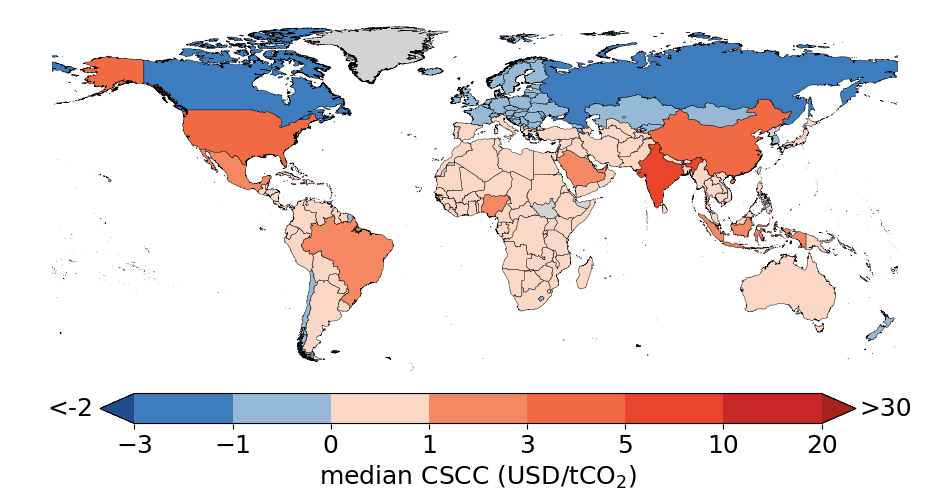

In [60]:
# Load country shapefile
world = gpd.read_file(rawDir + "ne_10m_admin_0_countries.shp")
world = world[world["ADM0_A3"] != "ATA"]

bins = [-3, -1, 0, 1, 3, 5, 10, 20] 

colors = [
    "#3d7cbd",  # Strong blue for large negative
    "#97b9d6",  # Blue-green
    "#fbd7c6",  # Light green
    "#f38863",  # Pale yellow-green
    "#f26a44",  # Neutral yellow (center ~0)
    "#e8452b",  # Light orange
    "#ce211a",  # Orange
    "#c62828",  # Red-orange
]

# Create a colormap and normalize it to the bins
cmap = mpl.colors.ListedColormap(colors).with_extremes(under="#214d8d", over="#a3241d") # #0a3e1f #5a0000
norm = mpl.colors.BoundaryNorm(bins, cmap.N)

# Plotting function
def plot_flux_map_discrete(column, title, ax):
    choropleth_df = world.merge(
        df_cscc_stats[["iso", column]], left_on="ADM0_A3", right_on="iso", how="left"
    )
    choropleth_df["bin"] = pd.cut(choropleth_df[column], bins=bins)  # Bin the data
    choropleth_df.plot(
        column=column,
        cmap=cmap,
        linewidth=0.3,  # Thicker lines for clearer borders
        edgecolor="black",  # Country borders in black
        ax=ax,
        missing_kwds={"color": "lightgrey", "label": "No data"},
        norm=norm)
    #ax.set_title(title, fontsize=18)
    ax.set_axis_off()


# Create subplots for three maps
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot each map using discrete colors
plot_flux_map_discrete("CSCC_median", "Count (USD/tCO2)", ax)

# Add a color bar with discrete ticks
cbar_ax = fig.add_axes([0.2, 0.27, 0.63, 0.03])  # [left, bottom, width, height]

cbar = fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cbar_ax,
    orientation="horizontal",
    extend="both",
)

cbar.set_label(r"median CSCC (USD/tCO$_2$)", fontsize=18)  # Adjust label font size
cbar.ax.tick_params(labelsize=18)  # Adjust tick label font size

vmin_label = r"<-2"
vmax_label = r">30"


# Add text annotations next to the colorbar
cbar_ax.text(-0.06, 0.5, vmin_label, va='center', ha='right', transform=cbar_ax.transAxes, fontsize=18)
cbar_ax.text(1.055, 0.5, vmax_label, va='center', ha='left', transform=cbar_ax.transAxes, fontsize=18)

# Save the plots
plt.savefig(imgDir + "figure_2_ela_prt.jpg", format="jpg", dpi=300, bbox_inches="tight")
plt.show()

## Figure 3

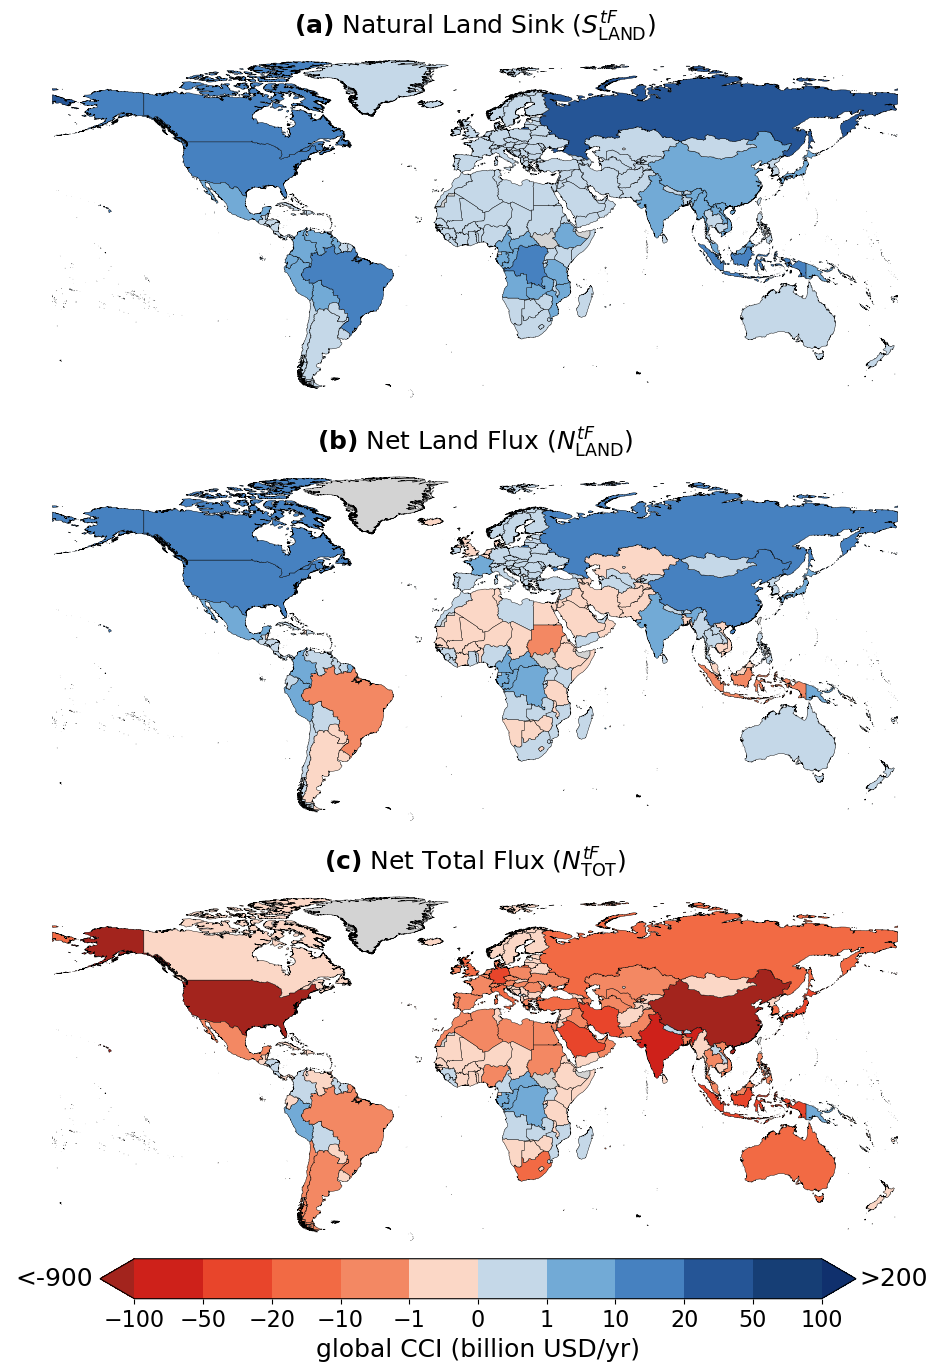

In [61]:
# Define bins and corresponding colors
bins = [-100, -50, -20, -10, -1, 0, 1, 10, 20, 50, 100]

colors = [
    "#ce211a",  # Orange
    "#e8452b",  # Light orange
    "#f26a44",  # Neutral yellow (center ~0)
    "#f38863",  # Pale yellow-green
    "#fbd7c6",  # Light green

    "#c5d8e8",  # Very pale blue-gray
    "#72aad6",  # Light blue
    "#4681c0",  # Medium blue
    "#255596",  # Dark blue
    "#163e75",  # Very dark blue (suggested)
]

# Create a colormap and normalize it to the bins
cmap = mpl.colors.ListedColormap(colors).with_extremes(under="#a3241d", over="#10306d") 
norm = mpl.colors.BoundaryNorm(bins, cmap.N)

# Plotting function
def plot_flux_map_discrete(column, title, ax):
    choropleth_df = world.merge(
        df_Wglob[["iso", column]], left_on="ADM0_A3", right_on="iso", how="left"
    )
    choropleth_df["bin"] = pd.cut(choropleth_df[column], bins=bins)  # Bin the data
    choropleth_df.plot(
        column=column,
        cmap=cmap,
        linewidth=0.3,  # Thicker lines for clearer borders
        edgecolor="black",  # Country borders in black
        ax=ax,
        missing_kwds={"color": "lightgrey", "label": "No data"},
        norm=norm,  # Use the discrete normalization
    )
    ax.set_title(title, fontsize=18)
    ax.set_axis_off()


# Create subplots for three maps
fig, axes = plt.subplots(3, 1, figsize=(12, 20))

plt.subplots_adjust(hspace=-0.4)  # Reduce vertical space between plots

# Plot each map using discrete colors
plot_flux_map_discrete("FaWglob_tf_median", r"$\bf{(a)}$ Natural Land Sink ($S^{tF}_\mathrm{LAND}$)", axes[0])
plot_flux_map_discrete("FabWglob_tf_median", r"$\bf{(b)}$ Net Land Flux ($N^{tF}_\mathrm{LAND}$)", axes[1])
plot_flux_map_discrete("FabcWglob_tf_median", r"$\bf{(c)}$ Net Total Flux ($N^{tF}_\mathrm{TOT}$)", axes[2])


# Add a color bar with discrete ticks
cbar_ax = fig.add_axes([0.2, 0.17, 0.63, 0.02])  # [left, bottom, width, height]
#cbar_ax = fig.add_axes([0.15, 0.15, 0.7, 0.02])  # Adjust the position and size

cbar = fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cbar_ax,
    orientation="horizontal",
    extend="both",
)

# Filter out "Total" row
filtered_df = df_Wglob[df_Wglob["iso"] != "Total"]


vmin_label = r"<-900"
vmax_label = r">200"
# Force all bin edges as ticks on the colorbar
cbar.set_ticks(bins)

# Add text annotations next to the colorbar
cbar_ax.text(-0.06, 0.5, vmin_label, va='center', ha='right', transform=cbar_ax.transAxes, fontsize=18)
cbar_ax.text(1.055, 0.5, vmax_label, va='center', ha='left', transform=cbar_ax.transAxes, fontsize=18)

cbar.set_label("global CCI (billion USD/yr)", fontsize=18)  # Adjust label font size
cbar.ax.tick_params(labelsize=16)  # Adjust tick label font size

# Save the plots
plt.savefig(imgDir + "figure_3_ela_prt.jpg", format="jpg", dpi=300, bbox_inches="tight")
plt.show()

## Figure 4

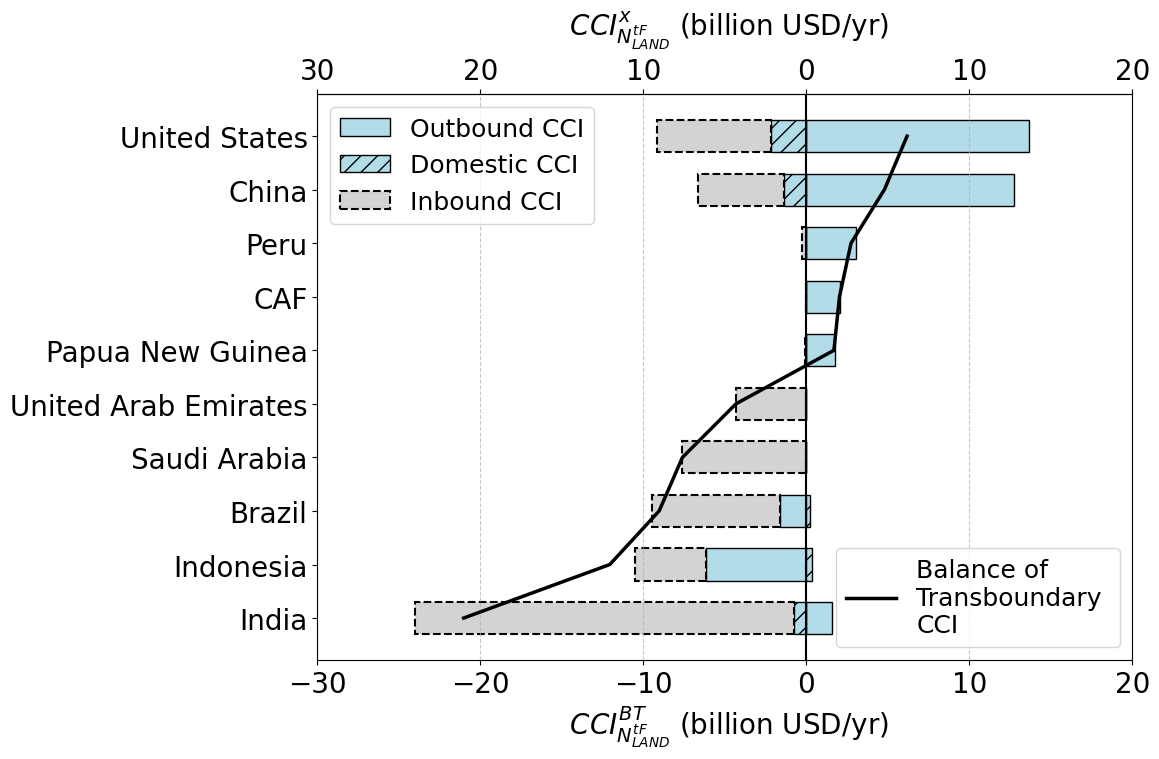

In [62]:
# Filter rows where CSCC_median > 0
df_filtered = df_final[df_final["CSCC_median"] > 0]

# Keep only the 'iso', 'Country', and columns containing 'Fab'
fab_columns = [
    col for col in df_filtered.columns
    if (col.startswith("Fab_") or col.startswith("FabW")) and col.endswith("_median")
]
columns_to_keep = ["iso", "Country"] + fab_columns

# Subset the dataframe
df_fab_positive_cscc = df_filtered[columns_to_keep].sort_values(by="FabWnet_tf_median", ascending=False)

# Get top 5 and bottom 5 (excluding NaNs if any)
top5 = df_fab_positive_cscc.dropna(subset=["FabWnet_tf_median"]).head(5)
bottom5 = df_fab_positive_cscc.dropna(subset=["FabWnet_tf_median"]).tail(5)

# Combine them
df_top_bottom_fabwnet = pd.concat([top5, bottom5])

# Optional: reset index for clean display
df_top_bottom_fabwnet = df_top_bottom_fabwnet.sort_values(by="FabWnet_tf_median", ascending=True).reset_index(drop=True)

# Update country names for specific ISO codes
df_top_bottom_fabwnet.loc[df_top_bottom_fabwnet["iso"] == "USA", "Country"] = "United States"
df_top_bottom_fabwnet.loc[df_top_bottom_fabwnet["iso"] == "CAF", "Country"] = "CAF"
#df_top_bottom_fabwnet.loc[df_top_bottom_fabwnet["iso"] == "PNG", "Country"] = "PNG"

# Extract data
countries = df_top_bottom_fabwnet["Country"]
fabwdom = df_top_bottom_fabwnet["FabWdom_tf_median"] * -1 # Invert sign for plotting
fabwin = df_top_bottom_fabwnet["FabWin_tf_median"] * -1 # Invert sign for plotting
fabwout = df_top_bottom_fabwnet["FabWout_tf_median"]
total = df_top_bottom_fabwnet["FabWnet_tf_median"]


# Setup plot
plt.rcParams.update({"font.size": 20})
fig, ax = plt.subplots(figsize=(12, 8))
bar_height = 0.6
y = np.arange(len(countries))

# Stack trackers
pos_stack = np.zeros(len(countries))
neg_stack = np.zeros(len(countries))

# Colors and styles
shared_color = "#b3dce9"

# Plot FabWout
for i in range(len(countries)):
    value = fabwout.iloc[i]
    base = pos_stack[i] if value > 0 else neg_stack[i]
    ax.barh(y[i], value, height=bar_height, color=shared_color, edgecolor = "black", left=base,
            label="Outbound CCI" if i == 0 else "")
    if value > 0:
        pos_stack[i] += value
    else:
        neg_stack[i] += value
        
# Plot FabWdom
for i in range(len(countries)):
    value = fabwdom.iloc[i]
    base = pos_stack[i] if value > 0 else neg_stack[i]
    ax.barh(y[i], value, height=bar_height, color=shared_color, edgecolor="black", hatch="//", left=base,
            label="Domestic CCI" if i == 0 else "")
    if value > 0:
        pos_stack[i] += value
    else:
        neg_stack[i] += value

# Plot FabWin
for i in range(len(countries)):
    value = fabwin.iloc[i]
    base = pos_stack[i] if value > 0 else neg_stack[i]
    ax.barh(y[i], value, height=bar_height, color = "#d3d3d3", edgecolor="black", linestyle= "--", linewidth=1.5, left=base,
            label="Inbound CCI" if i == 0 else "")
    if value > 0:
        pos_stack[i] += value
    else:
        neg_stack[i] += value

# Add total line
ax.plot(total, y, color="black", linewidth=2.5, linestyle="-", label="Balance of\nTransboundary \nCCI")


# Formatting
ax.set_yticks(y)
ax.set_yticklabels(countries)
ax.set_xlabel(r" $CCI^{BT}_{N^{tF}_{LAND}}$ (billion USD/yr)")
ax.axvline(0, color="black", linestyle="-", linewidth=1.5)
ax.set_xlim(-30, 20)
# Add mirrored top x-axis
secax = ax.secondary_xaxis("top")

# Match tick locations
secax.set_xticks(ax.get_xticks())

# Set custom labels: here, absolute values
labels = [str(abs(int(t))) for t in ax.get_xticks()]
secax.set_xticklabels(labels)

# Optional: add label
secax.set_xlabel(r" $CCI^x_{N^{tF}_{LAND}}$ (billion USD/yr)", labelpad=15)

#ax.legend(loc="lower right")
#ax.legend(loc="best")

# Get handles and labels from current plot
handles, labels = ax.get_legend_handles_labels()

# Separate them by label name
handles_top = [h for h, l in zip(handles, labels) if "Outbound" in l or "Domestic" in l or "Inbound" in l]
labels_top = [l for l in labels if "Outbound" in l or "Domestic" in l or "Inbound" in l]

handles_bottom = [h for h, l in zip(handles, labels) if "Balance" in l]
labels_bottom = [l for l in labels if "Balance" in l]

# Top left legend: CCI components
legend_top = ax.legend(handles_top, labels_top, loc="upper left", fontsize=18, frameon=True)

# Add it manually to keep the second one from replacing it
ax.add_artist(legend_top)

# Bottom right legend: Balance only
ax.legend(handles_bottom, labels_bottom, loc="lower right", fontsize=18, frameon=True)


# Grid
ax.grid(axis="x", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.savefig(imgDir + "figure_4_ela_prt.jpg", dpi=300)
plt.show()